# Analysis of the FSES UK Young People Survey

In 2013, the faculty of social and economic sciences (FSES) of the Comenius University Bratislava, conducted a project within their statistics class: Students were told to invite their friends to participate in a survey, covering a broad range of aspects of their lives: from movie and music preferences to personality traits, there was a huge variety of questions covered. The result of this project was the "Young People Survey" dataset, which - even though now almost ten years old - is a great resource for answering many extremely interesting data analysis questions. The dataset used here is available for download on [kaggle](https://www.kaggle.com/miroslavsabo/young-people-survey)

## What behavioral aspects hint at how much money young people spend?

When checking out the dataset for the first time, I found the spending habits the most interesting columns. Young people typically have only limited financial resources, so I think it's interesting to see what they spend it on and what are the best predictors in this dataset to forecast if someone would be more/less generous with their money. Maybe techno fans have a more expensive lifestyle than rock fans? Or the other way around? Let's find out! 

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.patches import FancyBboxPatch
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from scipy.stats import ttest_ind
import os

plt.style.use('dark_background')
mpl.rcParams['figure.dpi'] = 300

# if True, this will make the notebook create a new
# folder inside this repositories' directory called
# "Plots" and store PDFs of all the plots there in
# addition to showing them in-line
save_plots = False

if save_plots:
    if not os.path.exists("./Plots"):
        os.mkdir("./Plots")

In [2]:
# Define some nice colours from nord colour theme: https://www.nordtheme.com/
nord_aurora_green = '#a3be8c'
nord_aurora_orange = '#d08770'


# Define functions needed throughout this notebook

# function to get rounded edges for plotted bars
def round_bars(bar_container, rounding_size=0.0025, mutation_aspect=4):
    '''
    INPUT
    bar_container - matplotlib.container.BarContainer instance or
                    matplotlib.axis instance. Should contain the patches of the
                    bar chart or histogram that should get rounded corners
                    rounding_size - float describing how strongly they will be
                    rounded. The higher the value the more rounded they will
                    be.
    mutation_aspect - aspect ratio of the rounding. This should be roughly the
                      y-axis range divided by the x-axis range.
    OUTPUT:
    None
    
    If this function is applied to the bars of a matplotlib bar chart or
    histogram, it will create rounded corners for the bars to look more fancy.
    '''
    
    new_patches = []
    for patch in reversed(bar_container.patches):
        bb = patch.get_bbox()
        color=patch.get_facecolor()
        p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                            abs(bb.width), abs(bb.height),
                            boxstyle=("round,pad=-0.00,"
                                      + f"rounding_size={rounding_size}"),
                            ec=color, fc=color, zorder=10000,
                            mutation_aspect=mutation_aspect
                            )
        patch.remove()
        new_patches.append(p_bbox)
    
    for patch in new_patches:
        plt.gca().add_patch(patch)

def coef_weights(model, X_train, model_type="linear"):
    '''
    INPUT:
    model - the scikit-learn linear or MLPRegressor model instance  
    X_train - the training data, so the column names can be used
    model_type - choose between "linear" and "mlp" for a linear vs. neural
                 network model, respectively.
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Given a scikit-learn linear model instance as well as a pandas dataframe
    containing the training data, this function returns a pandas dataframe
    containing the name of the each variable in the training set as well as
    their coefficients and absolute coefficients, which can be seen as a
    measure of importance of the respective variable to the model.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns

    if model_type == "linear":
        coefs_df['coefs'] = model.coef_
        coefs_df['abs_coefs'] = np.abs(model.coef_)
    elif model_type == "mlp":
        coefs_df['coefs'] = np.sum(model.coefs_[0], axis=1)
        coefs_df['abs_coefs'] = np.sum(np.abs(model.coefs_[0]), axis=1)
    else:
        raise ValueError("'model_type' must be one of 'linear' or 'mlp'.")

    
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

def impute_val(dframe, col, ref_col=None, val="mode"):
    '''
    INPUT:
    dframe - pandas dataframe where NaN values should be imputed
    col - specific column in "dframe" where values should be imputed
    ref_col - optional paramter that can be used in NaN value positions should
              be taken over from a different "reference column" in "dframe"
    val - string which specifies which value should be imputed. Possible
          options are "mode" and "mean".

    OUTPUT:
    ret_frame - a pandas dataframe which is a copy of "dframe" with NaN values
                in "col" (or "ref_col") imputed.
    
    Given a pandas dataframe and a column, this function imputes (depending on
    the "val" parameter) either the mode or the mean for any existing NaN
    values in that column and returns the dataframe with the values imputed.
    If a new column has already been created, places where NaN values occurred
    in the dataset can also be used from a reference column (parameter
    "ref_col").
    
    '''
    assert val in ["mode", "mean"]

    ret_frame = dframe.copy()
    if ref_col is None:
        mask = ret_frame[col].isna()
    else:
        mask = ret_frame[ref_col].isna()

    ret_frame.loc[mask, col] = np.nan

    if val == "mode":
        if len(dframe[col].mode()) > 1:
            rep_val = ret_frame[col].mode().sum()/len(ret_frame[col].mode())
        else:
            rep_val = ret_frame[col].mode()[0]
    elif val == "mean":
        rep_val = ret_frame[col].mean()
    else:
        raise ValueError("'val' parameter must be either of 'mode' or 'mean'!")

    mask = ret_frame[col].isna()
    ret_frame.loc[mask, col] = rep_val

    return ret_frame

# Gather data

In [3]:
# read csv file into dataframe. Assuming it got downloaded from kaggle in
# folder above this project folder
df = pd.read_csv("../responses.csv")

# Assess data

In [4]:
# Let's take a look
df.head(5)

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,...,Age,Height,Weight,Number of siblings,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats
0,5.0,3.0,2.0,1.0,2.0,2.0,1.0,5.0,5.0,1.0,...,20.0,163.0,48.0,1.0,female,right handed,college/bachelor degree,no,village,block of flats
1,4.0,4.0,2.0,1.0,1.0,1.0,2.0,3.0,5.0,4.0,...,19.0,163.0,58.0,2.0,female,right handed,college/bachelor degree,no,city,block of flats
2,5.0,5.0,2.0,2.0,3.0,4.0,5.0,3.0,5.0,3.0,...,20.0,176.0,67.0,2.0,female,right handed,secondary school,no,city,block of flats
3,5.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,...,22.0,172.0,59.0,1.0,female,right handed,college/bachelor degree,yes,city,house/bungalow
4,5.0,3.0,4.0,3.0,2.0,4.0,3.0,5.0,3.0,1.0,...,20.0,170.0,59.0,1.0,female,right handed,secondary school,no,village,house/bungalow


The column names in this data are often shortened versions of the questions asked in the survey. For example, the answers to how much a person agrees with the statement *I spend a lot of money on gadgets.* on a scale from 1 to 5 are summarized under the column name "Spending on gadgets". The mapping between the summarized column names and the original questions is saved in the `columns.csv` file.
Let's load that as well, in case we need it for reference. Again we assume it's in the directory above this project's directory.

In [5]:
column_df = pd.read_csv("../columns.csv")

# Let's take a look
column_df.head(5)

,original,short
0,I enjoy listening to music.,Music
1,I prefer.,Slow songs or fast songs
2,"Dance, Disco, Funk",Dance
3,Folk music,Folk
4,Country,Country


Let's see what datatypes we have in our dataframe and how many of each we have:

In [6]:
df.dtypes.value_counts()

float64    134
object      11
int64        5
dtype: int64

We have 134 floats, 5 ints, which sum to 139 numeric values, as well as 11 categorical values (of type 'object').
Now let's see if there are a lot of NaNs in our dataset

In [7]:
print(f"We have {df.isna().sum().sum()} NaN values, "
      + f"out of a total of {df.shape[0]*df.shape[1]} values.")

We have 608 NaN values, out of a total of 151500 values.


# Clean data

In order to clean the dataset, I will at first come up with an idea to use numeric values for the categorical variables, then I will impute the mode for the NaN values of the categorical variables. Since there are typically very few answers missing per variable, this seems like a legitimate way to go at least for this dataset. For missing values of float variables, I will impute the mean instead. 

In [8]:
# For the views column, it is the first time we encounter non-numeric values in
# the dataset. Let's find out which these are and how we can deal with them.

objects_list = df.columns[df.dtypes == 'object']

for obj in objects_list:
    print(f"{obj} values:")
    print(df[obj].value_counts())
    print("\n")

Smoking values:
tried smoking     430
never smoked      208
current smoker    189
former smoker     175
Name: Smoking, dtype: int64


Alcohol values:
social drinker    659
drink a lot       222
never             124
Name: Alcohol, dtype: int64


Punctuality values:
i am always on time        399
i am often early           327
i am often running late    282
Name: Punctuality, dtype: int64


Lying values:
sometimes                        549
only to avoid hurting someone    270
everytime it suits me            138
never                             51
Name: Lying, dtype: int64


Internet usage values:
few hours a day            744
less than an hour a day    139
most of the day            124
no time at all               3
Name: Internet usage, dtype: int64


Gender values:
female    593
male      411
Name: Gender, dtype: int64


Left - right handed values:
right handed    906
left handed     101
Name: Left - right handed, dtype: int64


Education values:
secondary school                 

From the printout, we see that there are 11 non-numeric categories: "Smoking", "Alcohol", "Punctuality", "Lying", "Internet usage", "Gender", "Left - right handed", "Education", "Only child", "Village - town", "House - block of flats"
This is how I will replace them with numeric values:

`Lying`: create new column "Lying num" which will contain the following values w.r.t. the currently stored answers

- never: 0
- only to avoid hurting someone: 1
- sometimes: 2
- everytime it suits me: 3

`Punctuality`: create new column "Punctuality num" which will contain the following values w.r.t. the currently stored answers

- i am often running late: 0
- i am always on time: 1
- i am often early: 2

`Internet usage`: create new column "Internet usage num" which will contain the following values w.r.t. the currently stored answers

- no time at all: 0
- less than an hour a day: 1
- few hours a day: 2
- most of the day: 3

`Smoking`:
- never smoked: 0
- tried smoking: 1
- former smoker: 2
- current smoker: 3

`Alcohol`
- never: 0
- social drinker: 1
- drink a lot: 2

`Gender`:
Dummy variable containing 0/1 for each category

`Left - right handed`:
Dummy variable containing 0/1 for each category

`Education`:
- currently a primary school pupil: 0
- primary school: 1
- secondary school: 2
- college/bachelor degree: 3
- masters degree: 4
- doctorate degree: 5

`Only child`:
- yes: 1
- no: 0

`Village - town`:
- city: 1
- village: 0

`House - block of flats`:
- house/bungalow: 1
- block of flats: 0


In [9]:
new_cols = []

for obj in objects_list:
    new_cols.append(f"{obj} num")

numeric_df = df.assign(**dict.fromkeys(new_cols, 0))
    
numeric_df["Lying num"].where(
    ~(numeric_df["Lying"] == "only to avoid hurting someone"),
    other=1, inplace=True)

numeric_df["Lying num"].where(
    ~(numeric_df["Lying"] == "sometimes"),
    other=2, inplace=True)

numeric_df["Lying num"].where(
    ~(numeric_df["Lying"] == "everytime it suits me"),
    other=3, inplace=True)

# impute mode:
numeric_df = impute_val(numeric_df, "Lying num", ref_col="Lying")

numeric_df["Punctuality num"].where(
    ~(numeric_df["Punctuality"] == "i am always on time"),
    other=1, inplace=True)

numeric_df["Punctuality num"].where(
    ~(numeric_df["Punctuality"] == "i am often early"),
    other=2, inplace=True)

# impute mode:
numeric_df = impute_val(numeric_df, "Punctuality num", ref_col="Punctuality")

numeric_df["Internet usage num"].where(
    ~(numeric_df["Internet usage"] == "less than an hour a day"),
    other=1, inplace=True)

numeric_df["Internet usage num"].where(
    ~(numeric_df["Internet usage"] == "few hours a day"),
    other=2, inplace=True)

numeric_df["Internet usage num"].where(
    ~(numeric_df["Internet usage"] == "most of the day"),
    other=3, inplace=True)

# impute mode:
numeric_df = impute_val(numeric_df, "Internet usage num",
                        ref_col="Internet usage")


# change smoking variable
numeric_df["Smoking num"].where(
    ~(numeric_df["Smoking"] == "tried smoking"),
    other=1, inplace=True)

numeric_df["Smoking num"].where(
    ~(numeric_df["Smoking"] == "former smoker"),
    other=2, inplace=True)

numeric_df["Smoking num"].where(
    ~(numeric_df["Smoking"] == "current smoker"),
    other=3, inplace=True)

# impute mode:
numeric_df = impute_val(numeric_df, "Smoking num", ref_col="Smoking")


numeric_df["Alcohol num"].where(
    ~(numeric_df["Alcohol"] == "social drinker"),
    other=1, inplace=True)

numeric_df["Alcohol num"].where(
    ~(numeric_df["Alcohol"] == "drink a lot"),
    other=2, inplace=True)

# impute mode:
numeric_df = impute_val(numeric_df, "Alcohol num", ref_col="Alcohol")

numeric_df["Gender num"].where(
    ~(numeric_df["Gender"] == "female"),
    other=1, inplace=True)

# impute mode:
numeric_df = impute_val(numeric_df, "Gender num", ref_col="Gender")

numeric_df["Left - right handed num"].where(
    ~(numeric_df["Left - right handed"] == "left handed"),
    other=1, inplace=True)

# impute mode
numeric_df = impute_val(numeric_df, "Left - right handed num",
                        ref_col="Left - right handed")

numeric_df["Education num"].where(
    ~(numeric_df["Education"] == "primary school"),
    other=1, inplace=True)

numeric_df["Education num"].where(
    ~(numeric_df["Education"] == "secondary school"),
    other=2, inplace=True)

numeric_df["Education num"].where(
    ~(numeric_df["Education"] == "college/bachelor degree"),
    other=3, inplace=True)

numeric_df["Education num"].where(
    ~(numeric_df["Education"] == "masters degree"),
    other=4, inplace=True)

numeric_df["Education num"].where(
    ~(numeric_df["Education"] == "doctorate degree"),
    other=5, inplace=True)

# impute mode:
numeric_df = impute_val(numeric_df, "Education num", ref_col="Education")

numeric_df["Only child num"].where(
    ~(numeric_df["Only child"] == "yes"),
    other=1, inplace=True)

# impute mode:
numeric_df = impute_val(numeric_df, "Only child num", ref_col="Only child")

numeric_df["Village - town num"].where(
    ~(numeric_df["Village - town"] == "city"),
    other=1, inplace=True)

# impute mode:
numeric_df = impute_val(numeric_df, "Village - town num",
                        ref_col="Village - town")

numeric_df["House - block of flats num"].where(
    ~(numeric_df["House - block of flats"] == "house/bungalow"),
    other=1, inplace=True)

# impute mode:
numeric_df = impute_val(numeric_df, "House - block of flats num",
                        ref_col="House - block of flats")

numeric_df.drop(columns=objects_list, inplace=True)

print(numeric_df.dtypes.value_counts())

float64    145
int64        5
dtype: int64


In [10]:
# Impute values for columns that have not been of 'object' type

# for these variables we will impute the mean:
impute_mean_cols = ["Age", "Height", "Weight"]
for col in numeric_df.columns:
    if col in new_cols:
        continue  # these columns were already cleaned
    elif col in impute_mean_cols:
        numeric_df = impute_val(numeric_df, col, val="mean")
    else:
        numeric_df = impute_val(numeric_df, col, val="mode")

In [11]:
# check if there are still NaNs present:
numeric_df.isna().sum().value_counts()

0    150
dtype: int64

# Analyze data and visualize results

In this section in particular, two questions are assessed:

### Question 1: What things in particular do young people like to spend money on?

Now after having cleaned the data, I would like to answer to explore some questions with the dataset. At first, I would like to get an idea which of the many columns contain information concerning the spending habits. Therefore, I simply loop over the columns and check if they contain the string `"spending"`.

In [12]:
spending_list = []
for col in numeric_df.columns:
    if "spending" in col.lower():
        spending_list.append(col)

print(f"The following columns contain the string 'spending': {spending_list}")




The following columns contain the string 'spending': ['Entertainment spending', 'Spending on looks', 'Spending on gadgets', 'Spending on healthy eating']


In addition, I found two more interesting columns, that hint at people's spending habits `"Branded clothing"` and `"Shopping centres"`. I will add those to the list as well

In [13]:
spending_list.append("Branded clothing")
spending_list.append("Shopping centres")

We see there are six categories, all connected to how much young people spend for certain things:
Spending for entertainment, spending in appearance/fashion, spending on gadgets and spending on healthy food
as well as the general interest to go to shopping centres.
These seem to cover a large proportion of what one can spend money on (except for the "must-haves", like paying
for accomodation, tuition fees etc). Let's look at these columns now:

In [14]:
numeric_df[spending_list]

,Entertainment spending,Spending on looks,Spending on gadgets,Spending on healthy eating,Branded clothing,Shopping centres
0,3.0,3.0,1.0,3.0,5.0,4.0
1,4.0,2.0,5.0,2.0,1.0,4.0
2,4.0,3.0,4.0,2.0,1.0,4.0
3,3.0,4.0,4.0,1.0,3.0,4.0
4,3.0,3.0,2.0,4.0,4.0,3.0
...,...,...,...,...,...,...
1005,3.0,4.0,3.0,4.0,4.0,5.0
1006,1.0,1.0,5.0,3.0,1.0,1.0
1007,2.0,2.0,2.0,5.0,5.0,2.0
1008,5.0,3.0,3.0,3.0,1.0,2.0


Like in the rest of the questionnaire, these values range from 1 to 5, where 1 means spending a low amount and 5 means spending a lot of money for something.

I would like to create a new column, which should be an aggregate value of the four columns, to identify people who like to spend their money and people who are more economical. I decide to simply take the sum of those values for now.

In [15]:
numeric_df["Total Spending"] = numeric_df[spending_list].sum(axis="columns")

To get a feeling of whether young people see themselves spending a lot of money in general, let's look at the histograms of the items in spending_list as well as the new "Total Spending" column!

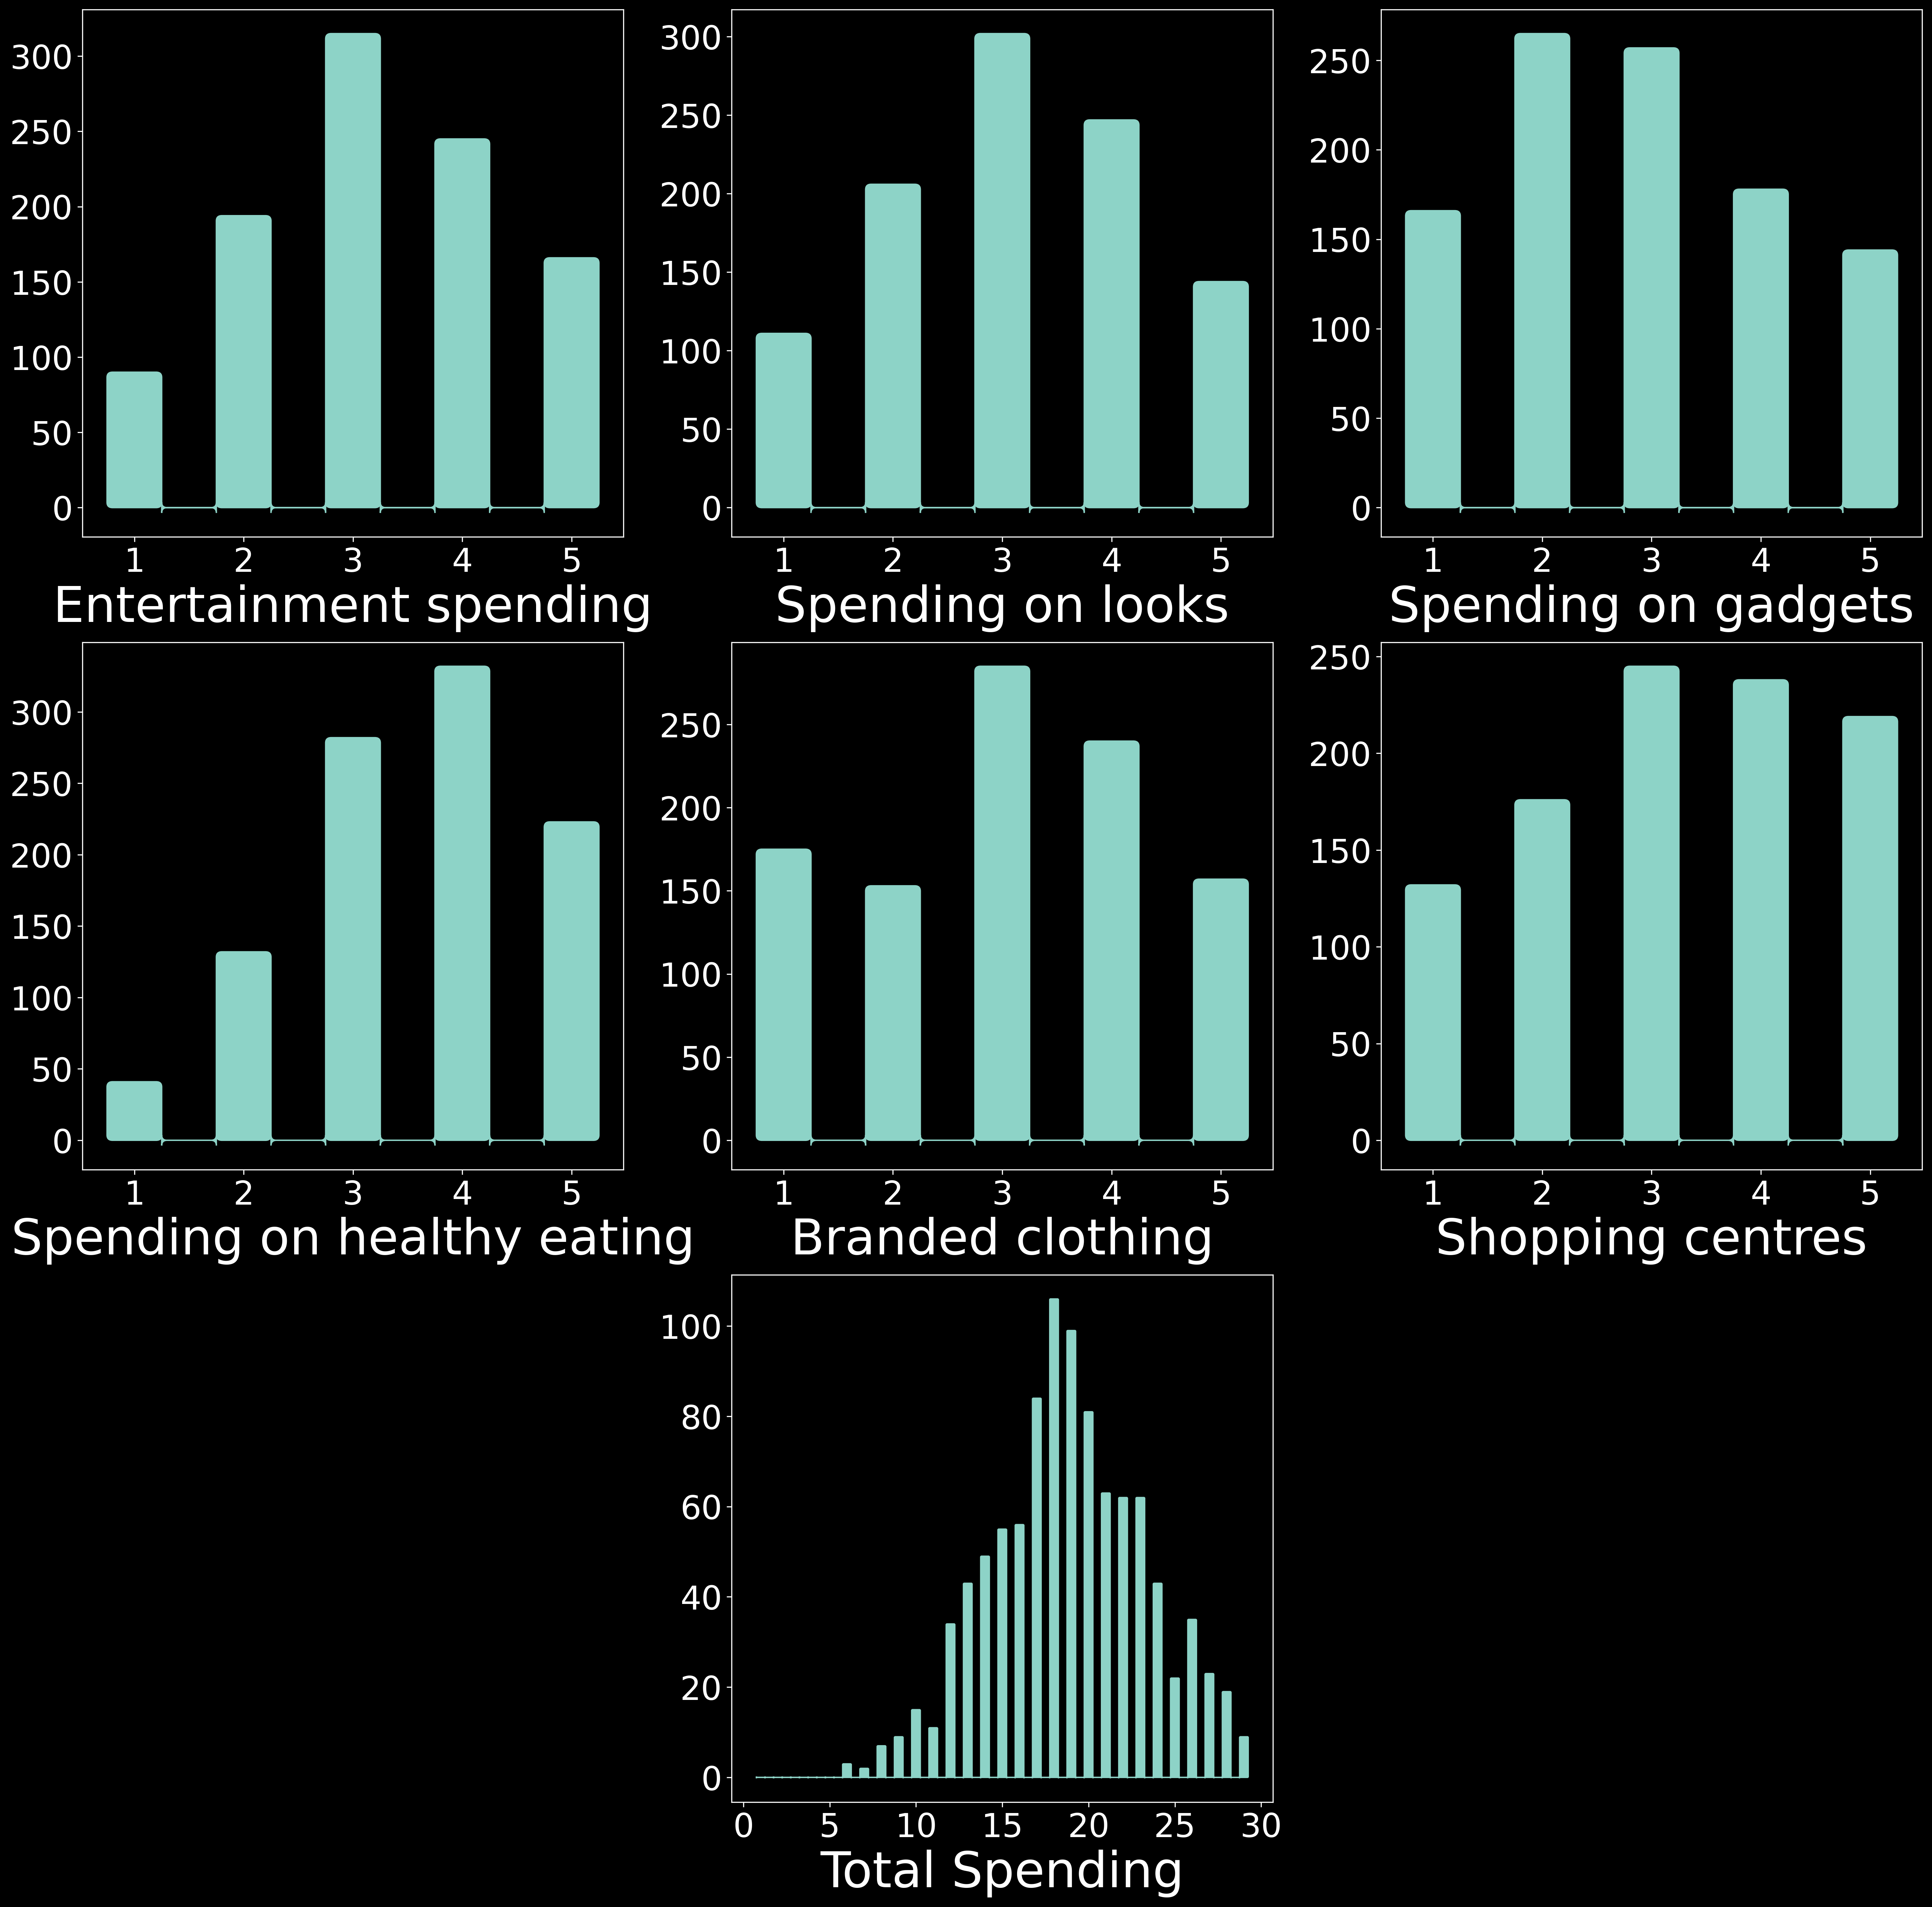

In [16]:
width = 0.25

lower_edges = np.arange(1, 6) - width
upper_edges = np.arange(1, 6) + width
edges = np.sort(np.concatenate((lower_edges, upper_edges)))

total_lower_edges = np.arange(1, 30) - width
total_upper_edges = np.arange(1, 30) + width
total_edges = np.sort(np.concatenate((total_lower_edges, total_upper_edges)))

plt.figure(figsize=(24, 24))

for idx, col in enumerate(
    numeric_df[spending_list + ["Total Spending"]].columns):

    if (idx + 1) == 7:
        current_idx = 7
    else:
        current_idx = idx

    plt.subplot(3,3, current_idx + 1)
    if (current_idx + 1) == 8:
        n, bins, patches = plt.hist(numeric_df[col], bins=total_edges)
        yrange = np.max(n)-np.min(n)
        xrange = np.max(bins)-np.min(bins)
        round_bars(patches, rounding_size=0.05, mutation_aspect=yrange/xrange)
    else:
        n, bins, patches = plt.hist(numeric_df[col], bins=edges)
        yrange = np.max(n)-np.min(n)
        xrange = np.max(bins)-np.min(bins)
        round_bars(patches, rounding_size=0.05, mutation_aspect=yrange/xrange)

    plt.xlabel(col, fontsize=36)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)

if save_plots:
    plt.savefig("Plots/spending_overview.png", dpi=300, bbox_inches="tight")

plt.show()
plt.close()

The results are extremely interesting! In general, it seems like the most votes are at the center value, which means a lot of people think they spend *some* amount of money on these things, but neither a very high nor a very low amount.

There are also some other effects to consider here: First, there are always people who simply choose the middle value for all given answers, because they are not really motivated to do the survey. On the other hand, there is often a tendency to choose the answer that is "most accepted". In the case of spending habits, one might be more drawn towards a medium value, since choosing a high value would mean to have a too luxurious lifestyle, while a low value could be considered stingy.

This effect can also be observed when looking at the *Spending on healthy eating* result. This seems to be the distribution that is most tilted towards higher values, which hints at people choosing a higher value here since spending money for healthy food is seen as more positive in general.

For the aggregated "Total Spending" columns, we see that overall the distribuiton is not centered, but the peak is at a value higher than the central value, which shows that averaged over all spending categories people spend - or *think* they spend - more than a "standard" amount of money.

The distributions most leaned towards higher spending are *Spending on healthy eating* and *Shopping centers*, which can be seen as a trend that a significant fraction of young people spend a high amount of money there.

### Question 2: Do spending habits differ significantly for male vs female persons and for persons with higher vs. lower formal education?

Since we are already looking at the spending habit distributions, let us see if they differ for some demographic aspects. In particular, I am interested in comparing the distributions for male/female persons and people with different educational backgrounds.


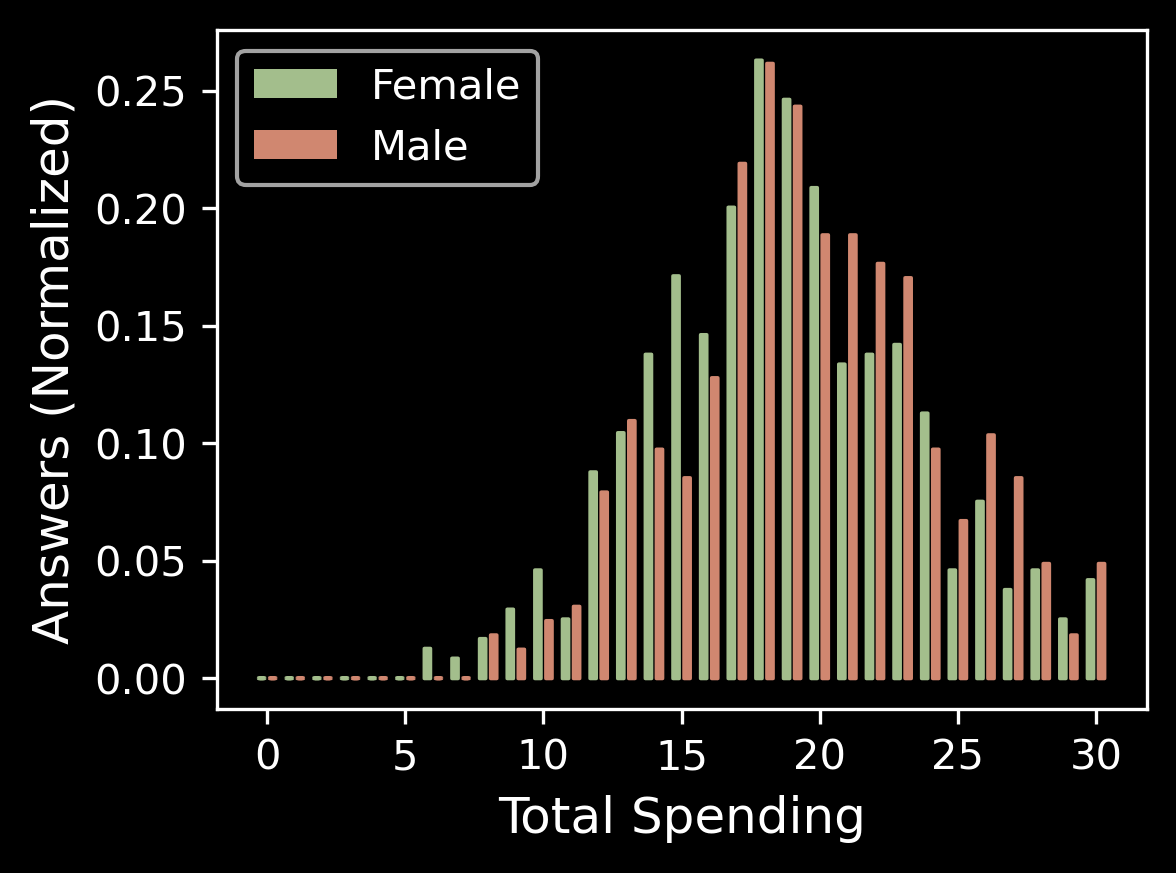

In [17]:
width = 0.2

lower_edges = np.arange(0, 31) - width
upper_edges = np.arange(0, 31) + width
total_edges = np.sort(np.concatenate((lower_edges, upper_edges)))

plt.figure(figsize=(4, 3))

fem_spending = numeric_df[numeric_df["Gender num"] == 1]["Total Spending"]
male_spending = numeric_df[numeric_df["Gender num"] == 0]["Total Spending"]


fem_hist, fem_edges = np.histogram(fem_spending,
                                   bins=total_edges, density=True)

male_hist, male_edges = np.histogram(male_spending,
                                     bins=total_edges, density=True)
fem_hist = fem_hist[0::2]
male_hist = male_hist[0::2]

fem_plot = plt.bar(np.arange(0, 31)-width, fem_hist, label="Female",
                   color=nord_aurora_green, width=width)

male_plot = plt.bar(np.arange(0, 31)+width, male_hist, label="Male",
                    color=nord_aurora_orange, width=width)

plt.legend(loc="upper left")
yrange = 0.5
xrange = 30
round_bars(fem_plot, rounding_size=0.002, mutation_aspect=yrange/xrange)
round_bars(male_plot, rounding_size=0.002, mutation_aspect=yrange/xrange)
plt.xlabel("Total Spending", fontsize=12)
plt.ylabel("Answers (Normalized)", fontsize=12)
if save_plots:
    plt.savefig("Plots/gender_histogram.png", dpi=300, bbox_inches="tight")

plt.show()
plt.close()

We clearly see that male persons tend to have higher total spending values compared to female persons, especially if we have a look at the bars just above/below the peak. The peak itself seems to be at a similar place for both genders. It is also interesting to see that there at very high values (specifically 26 and 27) we see a "mini peak" for male persons, which means there are overall more of them having a very expensive lifestyle compared to women.

I would like to find out if the difference between the two populations is significant, which is why we will run a quick hypothethis test:

In [18]:
# Do a quick Welsh's t-test:
stats, p_val = ttest_ind(fem_spending, male_spending, equal_var=False)
print(f"p_value: {p_val}")

p_value: 0.004168901879688971


Since the p-value is below a significance level of 5% (actually even below 1%), we can be quite confident that the two population means are not the same (i.e. we reject the null hypothesis of equal means) and thus there is a significant difference in spending habits between men and women. 

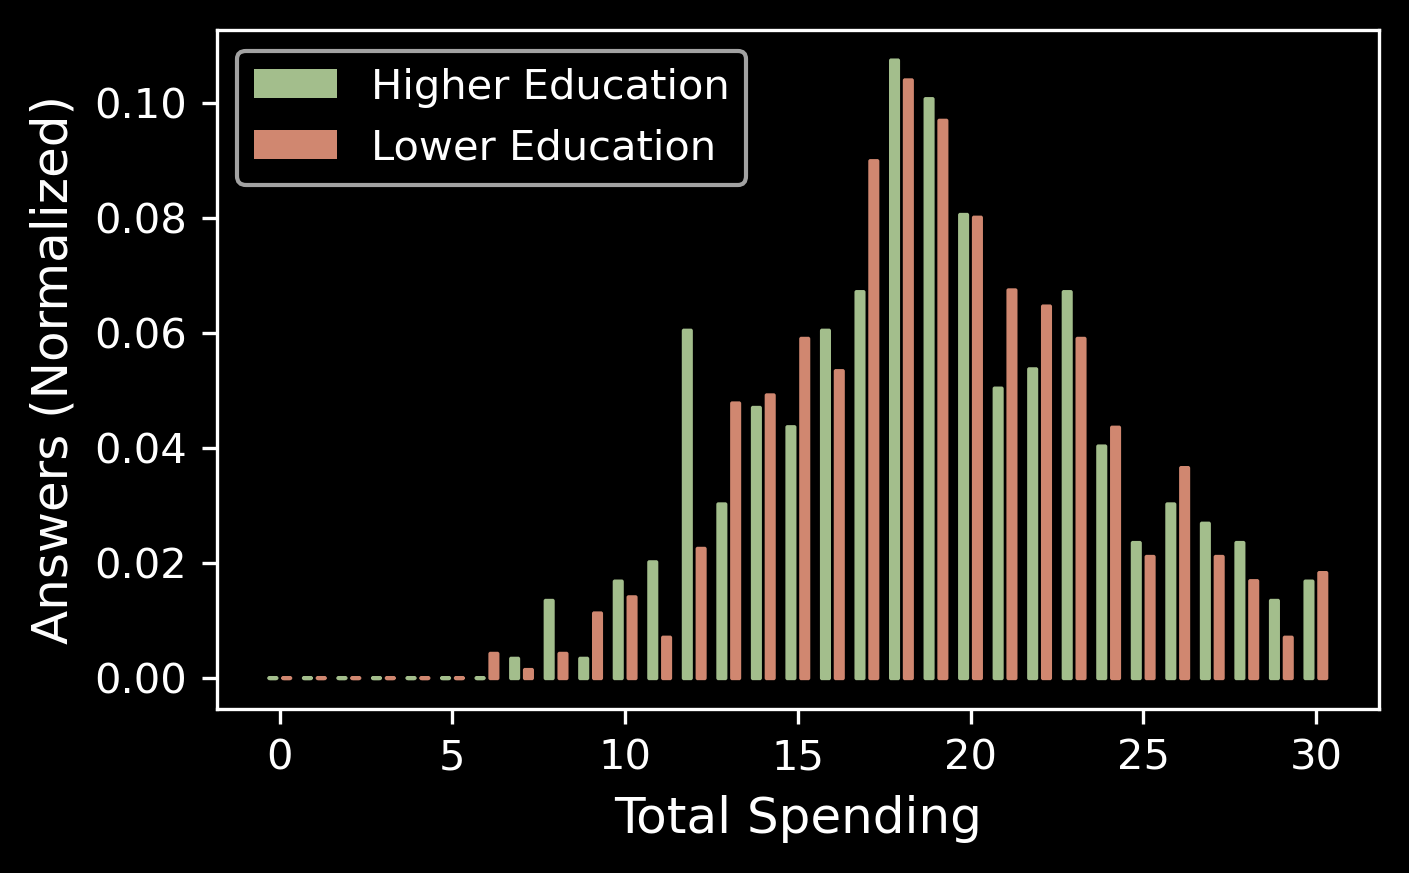

In [19]:
# higher education mask: education at least bachelor degree 
higher_ed_mask = (numeric_df["Education num"] > 2)
width = 0.2

lower_edges = np.arange(0, 31) - width
upper_edges = np.arange(0, 31) + width
total_edges = np.sort(np.concatenate((lower_edges, upper_edges)))

plt.figure(figsize=(5, 3))

high_ed_spending = numeric_df[higher_ed_mask]["Total Spending"]
low_ed_spending = numeric_df[~higher_ed_mask]["Total Spending"]

high_ed_hist, high_ed_edges = np.histogram(high_ed_spending, bins=total_edges)
low_ed_hist, low_ed_edges = np.histogram(low_ed_spending, bins=total_edges)
high_ed_hist = high_ed_hist[0::2]
low_ed_hist = low_ed_hist[0::2]

high_ed_plot = plt.bar(np.arange(0, 31)-width,
                       high_ed_hist/np.sum(high_ed_hist),
                       label="Higher Education",
                       color=nord_aurora_green, width=width)

low_ed_plot = plt.bar(np.arange(0, 31)+width, low_ed_hist/np.sum(low_ed_hist),
                      label="Lower Education",
                      color=nord_aurora_orange, width=width)
plt.legend(loc="upper left")
yrange = 0.5
xrange = 30
round_bars(high_ed_plot, rounding_size=0.002, mutation_aspect=yrange/xrange)
round_bars(low_ed_plot, rounding_size=0.002, mutation_aspect=yrange/xrange)
plt.xlabel("Total Spending", fontsize=12)
plt.ylabel("Answers (Normalized)", fontsize=12)
if save_plots:
    plt.savefig("Plots/education_histogram.png", dpi=300, bbox_inches="tight")

plt.show()
plt.close()

In [20]:
# Do a quick Welsh's t-test:
stats, p_val = ttest_ind(high_ed_spending, low_ed_spending, equal_var=False)
print(f"p_value: {p_val}")

p_value: 0.7327965839877252


Here the distributions look very similar. It seems there is not a big difference in spending behavior depending on the educational background, which is interesting, since a higher education should lead to higher payment and thus possibly to a more "luxorious" lifestyle. However, since we are dealing with young people here, most of them will probably not have a regular income yet. Still, access to higher education is (unfortunately) typically also highly correlated with the social background of a person, which could still lead to a higher "income" (e.g. additional money from parents and/or other relatives) for them. This is not really visible here though.

What is very interesting is the single bin at 12 being very high for people with higher education. It is especially interesting that the neighboring values don't show this increase. However, it is hard to tell what exacty causes it and it could also be pure coincidence.

We can also see from the hypothesis test that we get a very high p-value, which makes it unlikely that any difference seen in the two distributions is significant.

### Question 3: Which of the various views/hobbys/interests of young people are most strongly correlated with their spending habits?

Now I would like to find out which values are most strongly correlated with "Total Spending". Since the amount of columns in this dataset is huge, I separated them into smaller groups, taking the same categories as in the kaggle page: Music preferences, movie preferences, hobbies & interests, phobias & health habits, personality traits & beliefs/opinions and finally demographics.

In [21]:
# create category lists of columns

spend_cols = ["Total Spending"] + spending_list

music_cols = ['Slow songs or fast songs', 'Dance', 'Folk', 'Country',
              'Classical music', 'Musical', 'Pop', 'Rock', 'Metal or Hardrock',
              'Punk', 'Hiphop, Rap', 'Reggae, Ska', 'Swing, Jazz',
              'Rock n roll', 'Alternative', 'Latino', 'Techno, Trance',
              'Opera']

movie_cols = ['Movies', 'Horror', 'Thriller', 'Comedy', 'Romantic', 'Sci-fi',
              'War', 'Fantasy/Fairy tales', 'Animated', 'Documentary',
              'Western', 'Action']

hobby_cols = ['History', 'Psychology', 'Politics', 'Mathematics', 'Physics',
              'Internet', 'PC', 'Economy Management', 'Biology', 'Chemistry',
              'Reading', 'Geography', 'Foreign languages', 'Medicine', 'Law',
              'Cars', 'Art exhibitions', 'Religion', 'Countryside, outdoors',
              'Dancing', 'Musical instruments', 'Writing', 'Passive sport',
              'Active sport', 'Gardening', 'Celebrities', 'Shopping',
              'Science and technology', 'Theatre', 'Fun with friends',
              'Adrenaline sports', 'Pets']

phobi_cols = ['Flying', 'Storm', 'Darkness', 'Heights', 'Spiders', 'Snakes',
              'Rats', 'Ageing', 'Dangerous dogs', 'Fear of public speaking',
              'Smoking', 'Alcohol', 'Healthy eating']

views_cols = ['Daily events', 'Prioritising workload', 'Writing notes',
              'Workaholism', 'Thinking ahead', 'Final judgement',
              'Reliability', 'Keeping promises', 'Loss of interest',
              'Friends versus money', 'Funniness', 'Fake', 'Criminal damage',
              'Decision making', 'Elections', 'Self-criticism',
              'Judgment calls', 'Hypochondria', 'Empathy', 'Eating to survive',
              'Giving', 'Compassion to animals', 'Borrowed stuff',
              'Loneliness', 'Cheating in school', 'Health',
              'Changing the past', 'God', 'Dreams', 'Charity',
              'Number of friends', 'Punctuality', 'Lying', 'Waiting',
              'New environment', 'Mood swings', 'Appearence and gestures',
              'Socializing', 'Achievements', 'Responding to a serious letter',
              'Children', 'Assertiveness', 'Getting angry',
              'Knowing the right people', 'Public speaking', 'Unpopularity',
              'Life struggles', 'Happiness in life', 'Energy levels',
              'Small - big dogs', 'Personality', 'Finding lost valuables',
              'Getting up', 'Interests or hobbies', "Parents' advice",
              'Questionnaires or polls', 'Internet usage']

demo_cols = ["Age", "Height", "Weight", "Number of siblings", "Gender",
             "Left - right handed", "Education", "Only child",
             "Village - town", "House - block of flats"]

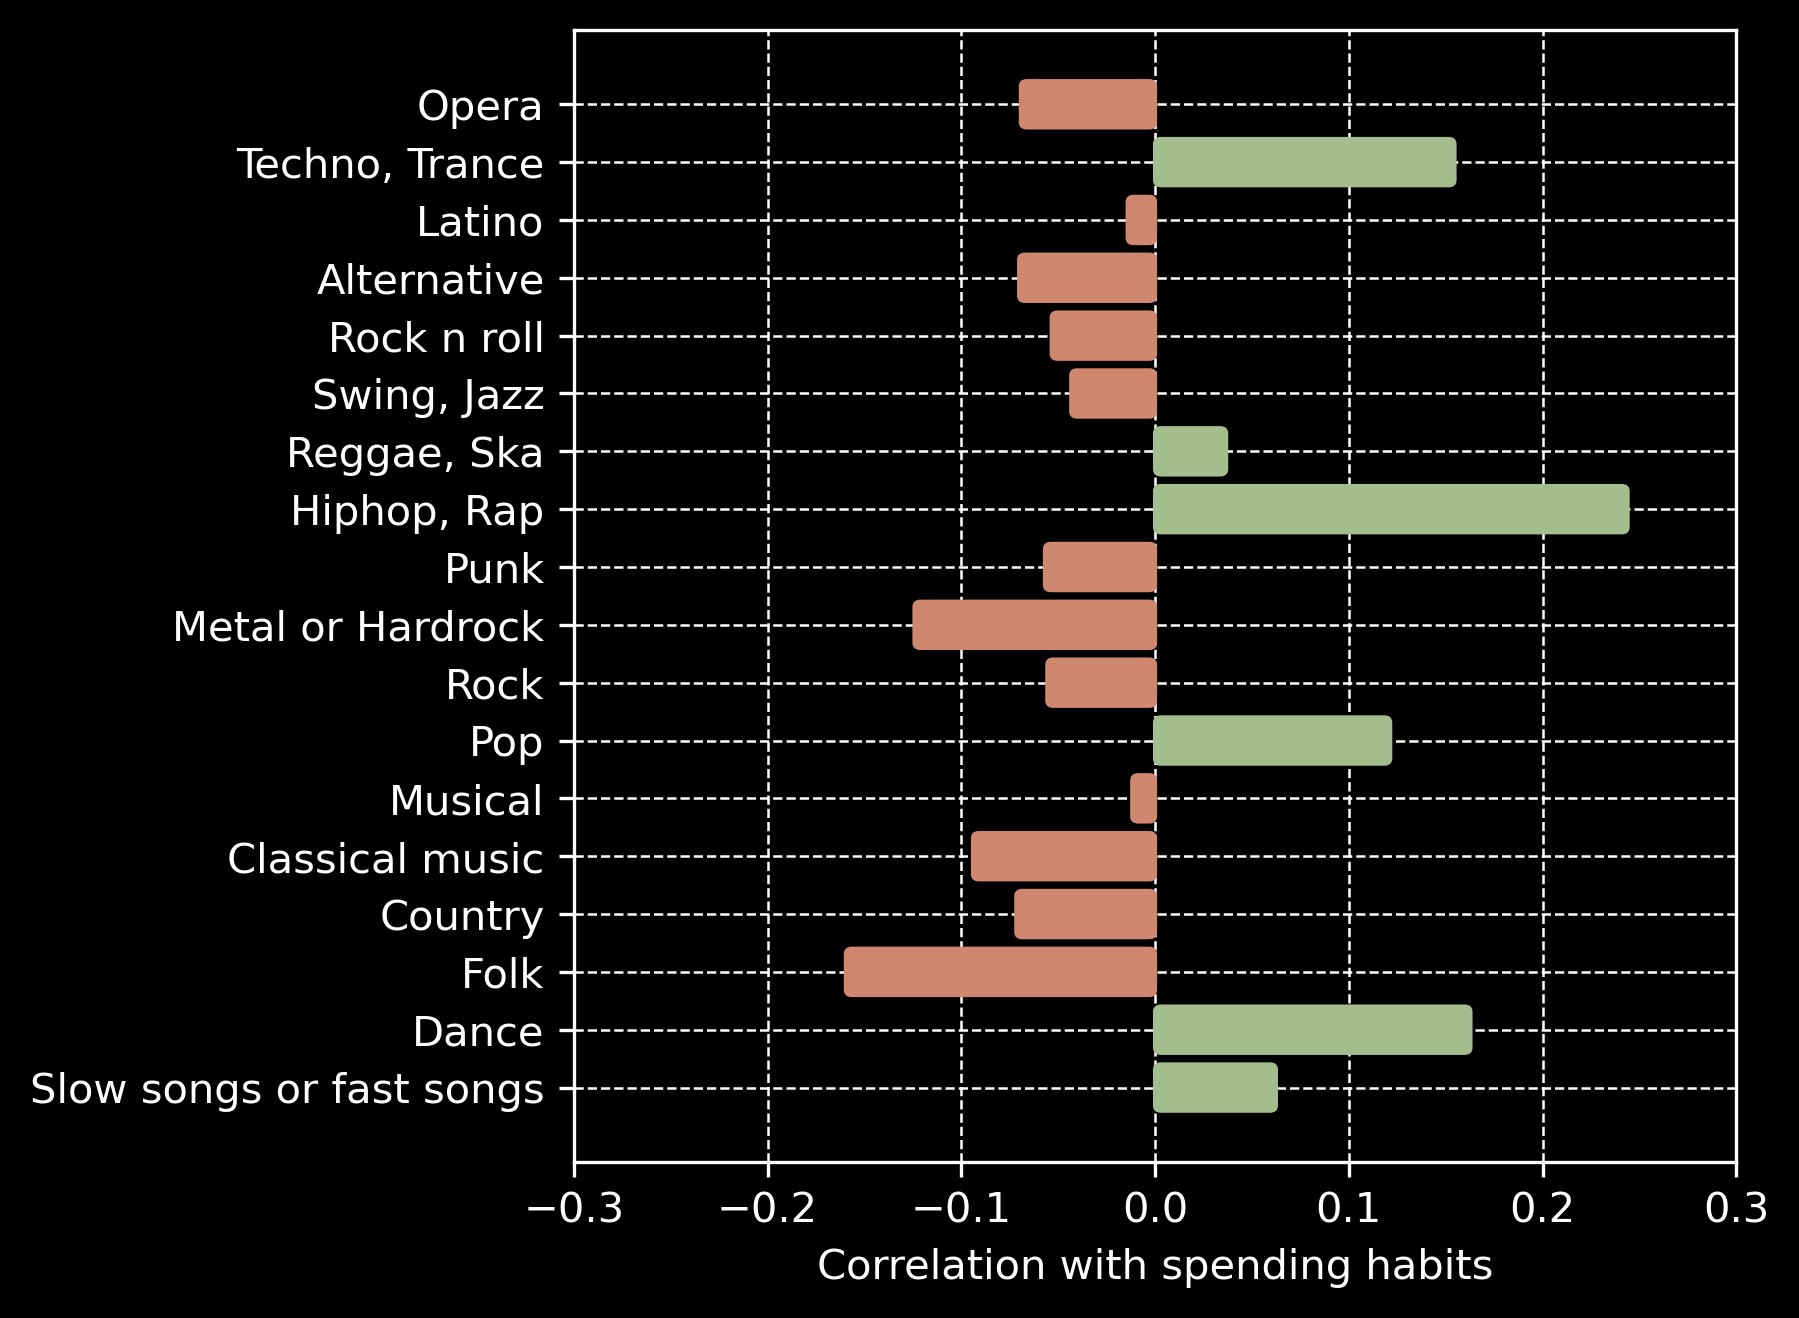

In [22]:
color_list = []

indices = numeric_df.corr()["Total Spending"][music_cols].index
values = numeric_df.corr()["Total Spending"][music_cols].values

for val in values:
    if val < 0:
        color_list.append(nord_aurora_orange)
    else:
        color_list.append(nord_aurora_green)

plt.figure(figsize=(5, 5))
bar = plt.barh(indices,
               values,
               zorder=5, color=color_list)

yrange = indices.shape[0]
xrange = 0.6
round_bars(bar, rounding_size=0.003, mutation_aspect=yrange/xrange)

plt.xlabel("Correlation with spending habits")
plt.xlim(-0.3, 0.3)
plt.grid(linestyle="dashed", zorder=-1000, linewidth=0.6)
if save_plots:
    plt.savefig("Plots/correlation_music.png", dpi=300, bbox_inches="tight")

plt.show()
plt.close()

We cannot really see any strong correlation of spending habits with music preference (which is what we would expect). The highest correlation we get for Hiphop and rap with a value of about 0.25. Even though the correlation is not super high, it's still interesting, since in these music genres, a luxurious livestyle is often propagated (e.g. wearing gold chains around the neck, driving expensive and fancy cars etc). The lowest correlation is found with Folk music, with a value at about -0.16. 

I think it is also interesting to see if there are strong correlations towards any of the individual spending habits depending on music interest. Let's do a single plot as before, but separated into the different spending categories.

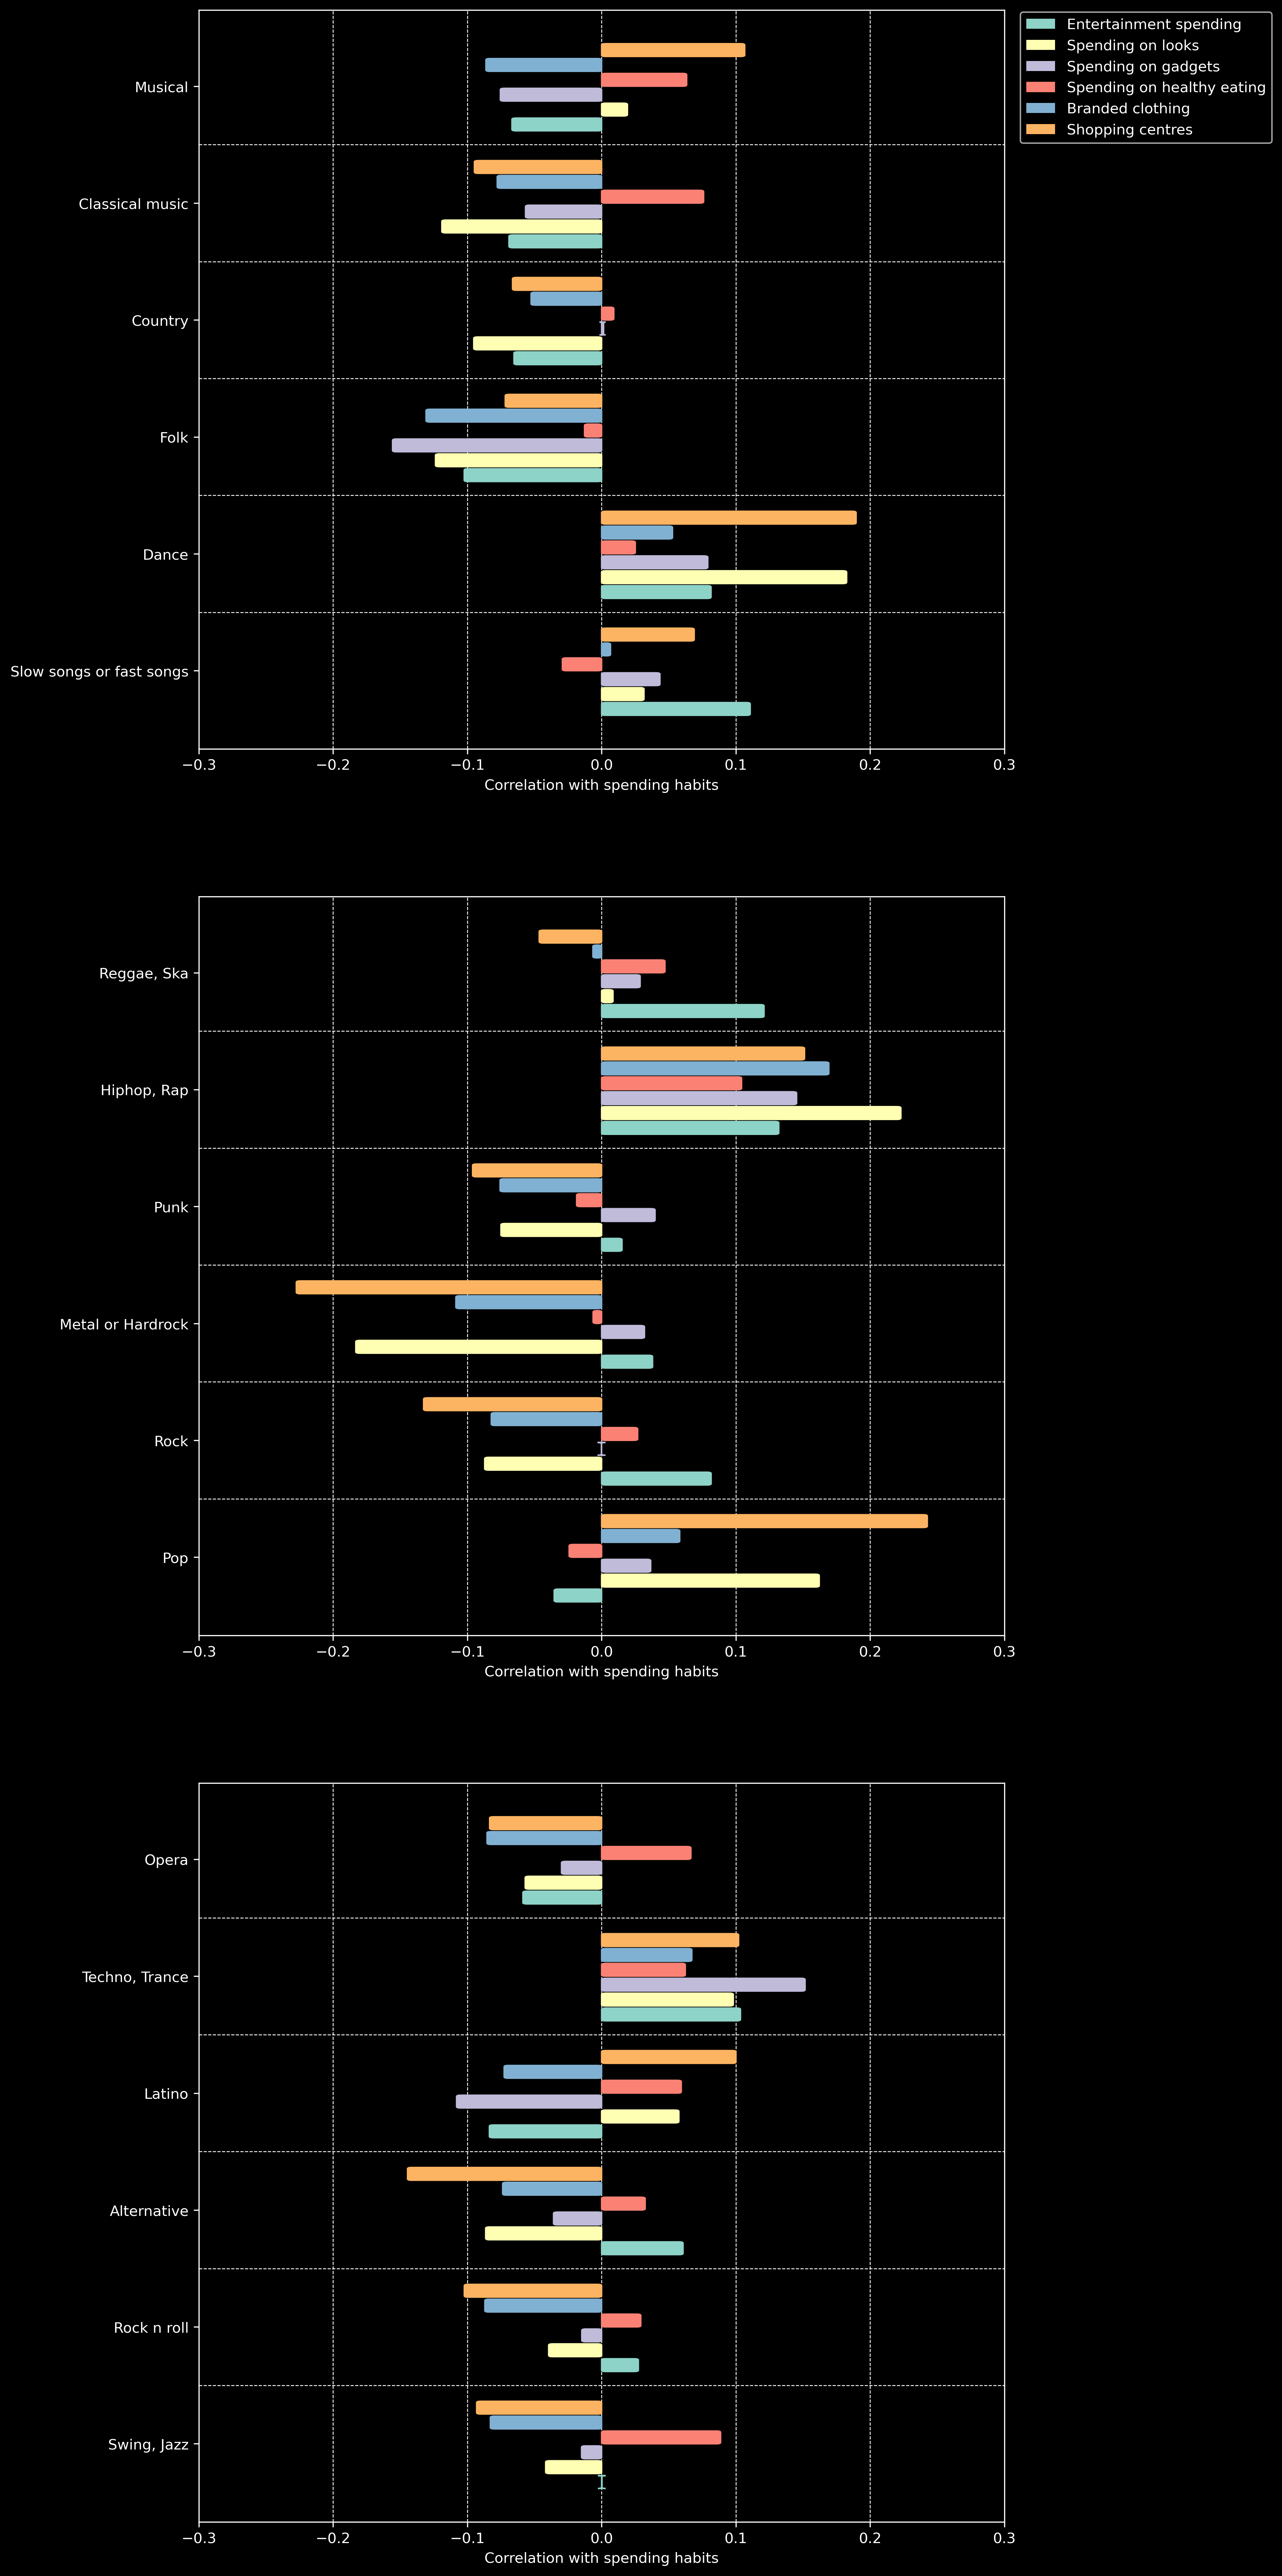

In [23]:
plt.figure(figsize=(10, 32))


for i in range(0, 18, 6):

    columns = numeric_df[spend_cols+music_cols].corr().loc[
        music_cols, spending_list].columns

    values = numeric_df[spend_cols+music_cols].corr().loc[
        music_cols, spending_list].values[i:i+6]

    plt.subplot(3, 1, int(i/6)+ 1)
    
    height = 0.3
    pad = 0.35
    major_pad = 2.75

    for idx, col in enumerate(columns):
        indices = np.arange(values.shape[0])*major_pad
        current_values = values[:, idx]
        bar = plt.barh(indices + (idx*pad), current_values, height=height,
                       zorder=5, label = col)

        round_bars(bar, rounding_size=0.003, mutation_aspect=10)

    plt.xlabel("Correlation with spending habits")
    plt.xlim(-0.3, 0.3)
    if (int(i/6) + 1) == 1:
        plt.legend(loc=(1.02, 0.82))
    
    plt.grid(linestyle="dashed", zorder=-1000, linewidth=0.6, axis="x")
    labels = numeric_df[spend_cols+music_cols].corr().loc[
        music_cols, spending_list].index[i:i+6]

    y_ticks_lower = (np.arange(values.shape[0])*major_pad)-(height)
    y_ticks_upper = y_ticks_lower + ((columns.shape[0]*height)+(height))
    full_yticks = np.concatenate((y_ticks_lower, y_ticks_upper))
    tick_x = np.linspace(-0.3, 0.3, 100)
    y_ticks = ((np.arange(values.shape[0])*major_pad)
               +(values.shape[1]*height)/2)

    full_yticks = (y_ticks[1:] + y_ticks[:-1])/2
    for tick in full_yticks:
        plt.plot(tick_x, np.full_like(tick_x, tick), linestyle="dashed",
                 color="white", linewidth=0.6)

    plt.yticks(ticks=((np.arange(values.shape[0])*major_pad)
                      + (values.shape[1]*height)/2), labels = labels)

if save_plots:
    plt.savefig("Plots/correlation_music_detailled.png", dpi=300, bbox_inches="tight")

plt.show()
plt.close()

Now let's take a look if we can identify any other variables/habits that highly correlate with spending a lot of money in general. Since there are many variables left, I will only look at the correlation with the `Total Spending` column for now

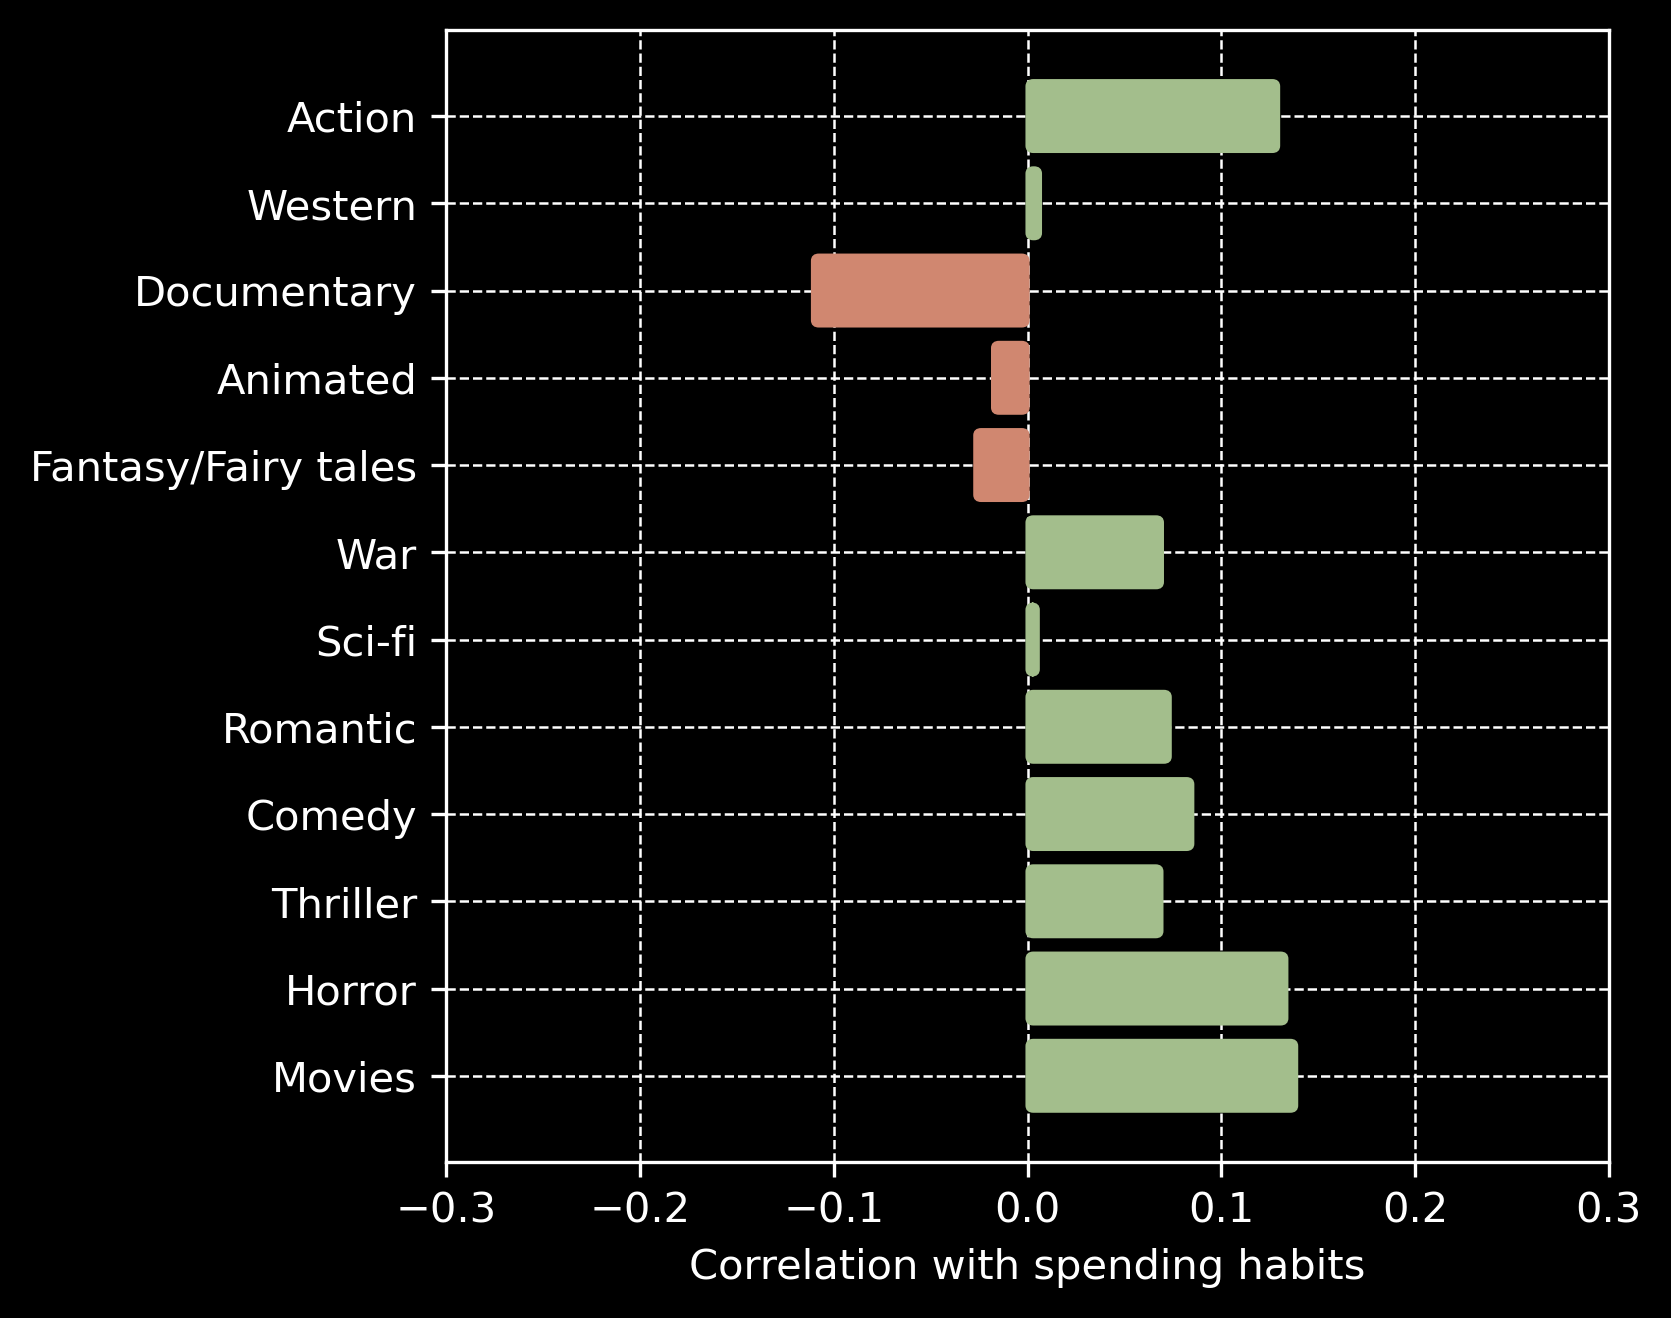

In [24]:
color_list = []

indices = numeric_df.corr()["Total Spending"][movie_cols].index
values = numeric_df.corr()["Total Spending"][movie_cols].values

for val in values:
    if val < 0:
        color_list.append(nord_aurora_orange)
    else:
        color_list.append(nord_aurora_green)

plt.figure(figsize=(5, 5))
bar = plt.barh(indices,
               values,
               zorder=5, color=color_list)

round_bars(bar, rounding_size=0.003, mutation_aspect=20)

plt.xlabel("Correlation with spending habits")
plt.xlim(-0.3, 0.3)
plt.grid(linestyle="dashed", zorder=-1000, linewidth=0.6)
if save_plots:
    plt.savefig("Plots/correlation_movies.png", dpi=300, bbox_inches="tight")

plt.show()
plt.close()

For movie preferences, correlations with spending habits are even lower than for music habits, and even the strongest correlations don't seem to reach even a correlation value of 0.15. This means it should be pretty difficult to predict spending habits from these features.

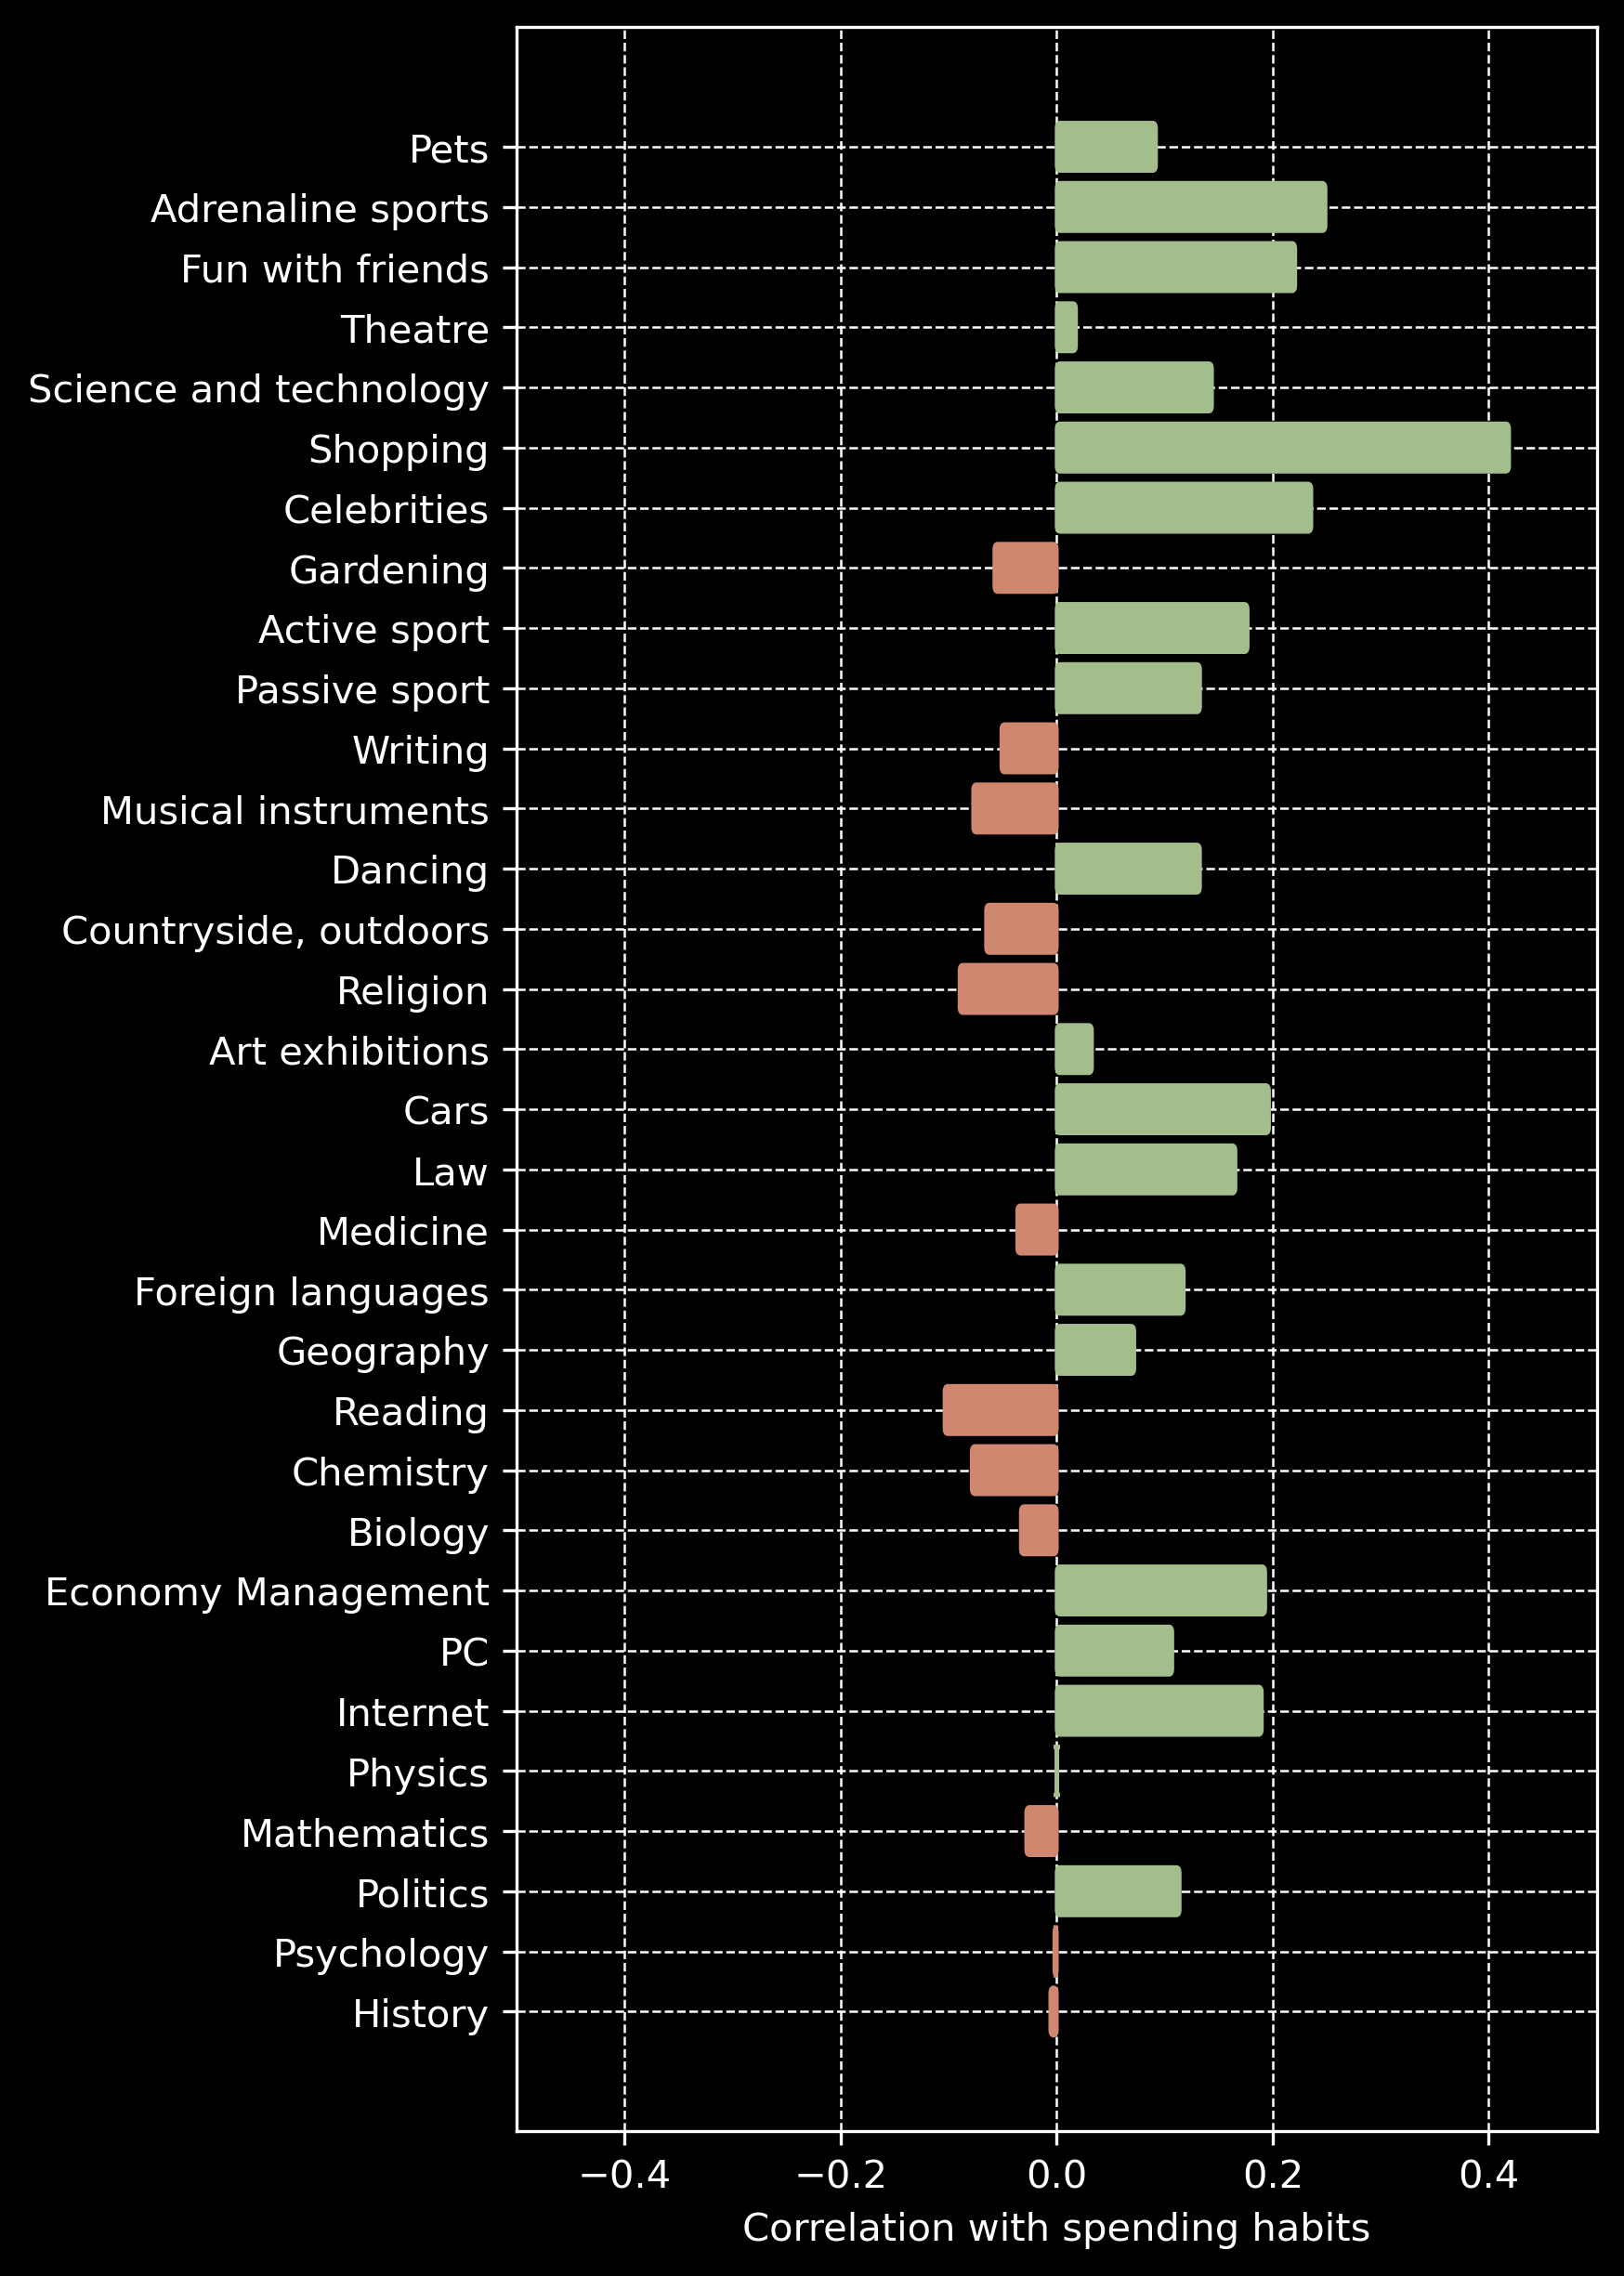

In [25]:
color_list = []

indices = numeric_df.corr()["Total Spending"][hobby_cols].index
values = numeric_df.corr()["Total Spending"][hobby_cols].values

for val in values:
    if val < 0:
        color_list.append(nord_aurora_orange)
    else:
        color_list.append(nord_aurora_green)

plt.figure(figsize=(5, 10))
bar = plt.barh(indices,
               values,
               zorder=5, color=color_list)

round_bars(bar, rounding_size=0.003, mutation_aspect=indices.shape[0])

plt.xlabel("Correlation with spending habits")
plt.xlim(-0.5, 0.5)
plt.grid(linestyle="dashed", zorder=-1000, linewidth=0.6)
if save_plots:
    plt.savefig("Plots/correlation_hobbies.png", dpi=300, bbox_inches="tight")

plt.show()
plt.close()

Compared to previous features, for the hobbies we actually see some that are more strongly correlated with the spending habits. One quite obvious feature to be correlated with spending money is `Shopping`. Other than that we have correlations of `Celebrities`, `Adrenaline Sports` and `Fun with Friends` to be rather high. Going out with friends and doing adrenaline sports like parachuting can cost a lot of money, so their correlations with spending habits is alse expected.

Interests in `Celebrities` correlating with more total spending is a bit more unexpected. Similar to the correlation with `Rap/Hiphop` music, celebrities often have quite a luxurious lifestyle, which fans might like to copy at least to a degree that they can still afford.

In [26]:
for i, view in enumerate(views_cols):
    if view == "Lying":
        views_cols[i] = "Lying num"
    elif view == "Internet usage":
        views_cols[i] = "Internet usage num"
    elif view == "Punctuality":
        views_cols[i] = "Punctuality num"
    else:
        continue

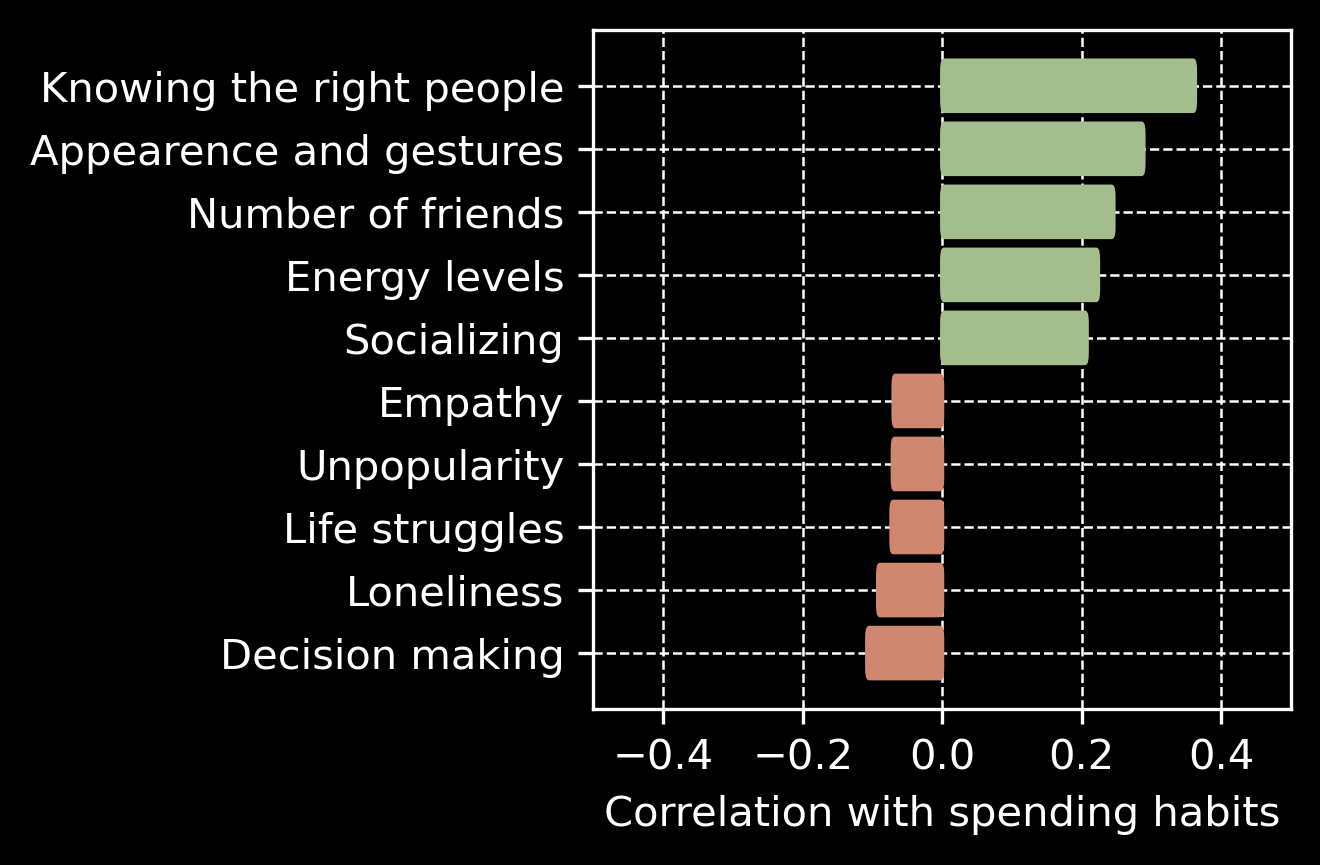

In [27]:
color_list = []

indices = numeric_df.corr()["Total Spending"][views_cols].index
values = numeric_df.corr()["Total Spending"][views_cols].values

# since there are many views/habits, only look at the five most strongly
# correlated and anti-correlated items
sorted_idx = np.concatenate((np.argsort(values)[:5], np.argsort(values)[-5:]))
sorted_values = values[sorted_idx]
sorted_indices = indices[sorted_idx]

for val in sorted_values:
    if val < 0:
        color_list.append(nord_aurora_orange)
    else:
        color_list.append(nord_aurora_green)

plt.figure(figsize=(3, 3))
bar = plt.barh(sorted_indices,
               sorted_values,
               zorder=5, color=color_list)

round_bars(bar, rounding_size=0.003, mutation_aspect=indices.shape[0])

plt.xlabel("Correlation with spending habits")
plt.xlim(-0.5, 0.5)
plt.grid(linestyle="dashed", zorder=-1000, linewidth=0.6)
if save_plots:
    plt.savefig("Plots/correlation_views.png", dpi=300, bbox_inches="tight")

plt.show()
plt.close()

In [28]:
column_df.loc[column_df['short'].isin(sorted_indices)]

,original,short
89,I take my time to make decisions.,Decision making
94,I am emphatetic person.,Empathy
99,I feel lonely in life.,Loneliness
106,I have lots of friends.,Number of friends
112,I am well mannered and I look after my appeara...,Appearence and gestures
113,I enjoy meeting new people.,Socializing
119,I always make sure I connect with the right pe...,Knowing the right people
121,I will find a fault in myself if people don't ...,Unpopularity
122,I cry when I feel down or things don't go the ...,Life struggles
124,I am always full of life and energy.,Energy levels


From the views colums we see that most correlated features with spending habits are people who "*make sure to connect with the right people*". This is interesting, since I would not have expected this to be the highest correlated amongst those. The "networking" people seem to have a more luxorious lifestyle, either because they can afford more (because they get better jobs and benefits due to their connections) or "connecting" with people costs money by itself.

Most other highly correlated features either deal with being a social person (similar to `Fun with Friends` in the previous plot) like `Number of friends` and `Socializing`. `Appereance and Gestures` is also highly correlated, which one would expect, since the answer says *"I am well mannered and I look after my appearance."*, which means they probably spend a lot of money for adequate clothing and other apparrel.

The least correlated features all deal with being socially isolated (loneliness, unpopularity) and struggling with life, like taking very long to make a decision. The `Decision making` feature is actually the least correlated, which could also mean that these people think really hard before they pay money for something they might not actually need.

Now, let's try to predict the spending habits from all available features using a simple linear model!

Let's take a look at the demographics features

In [29]:
for i, demo in enumerate(demo_cols):
    if demo == "Gender":
        demo_cols[i] = "Gender num"
    elif demo == "Left - right handed":
        demo_cols[i] = "Left - right handed num"
    elif demo == "Education":
        demo_cols[i] = "Education num"
    elif demo == "Only child":
        demo_cols[i] = "Only child num"
    elif demo == "Village - town":
        demo_cols[i] = "Village - town num"
    elif demo == "House - block of flats":
        demo_cols[i] = "House - block of flats num"
    else:
        continue

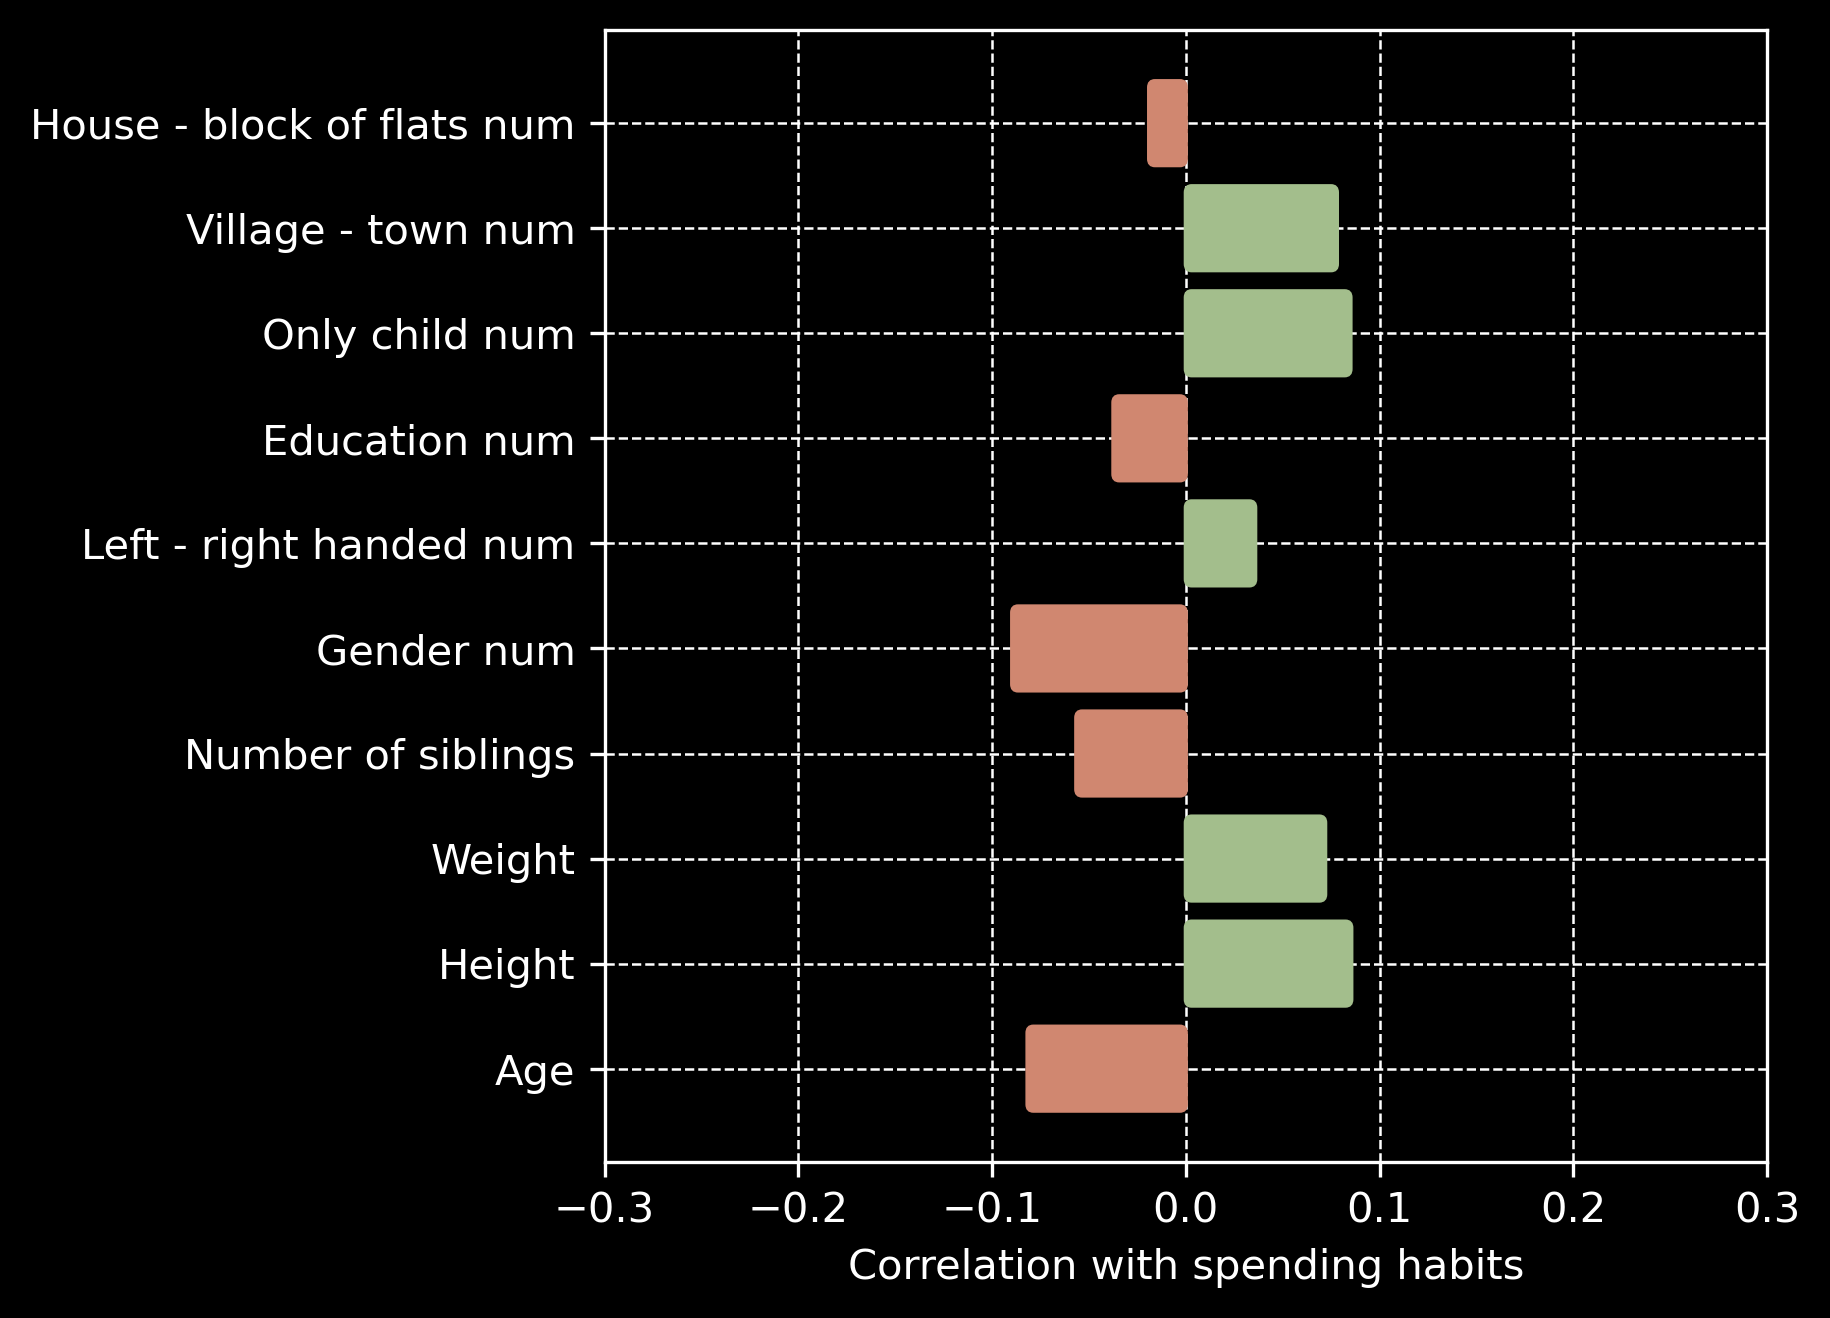

In [30]:
color_list = []

indices = numeric_df.corr()["Total Spending"][demo_cols].index
values = numeric_df.corr()["Total Spending"][demo_cols].values

for val in values:
    if val < 0:
        color_list.append(nord_aurora_orange)
    else:
        color_list.append(nord_aurora_green)

plt.figure(figsize=(5, 5))
bar = plt.barh(indices,
               values,
               zorder=5, color=color_list)

round_bars(bar, rounding_size=0.003, mutation_aspect=20)

plt.xlabel("Correlation with spending habits")
plt.xlim(-0.3, 0.3)
plt.grid(linestyle="dashed", zorder=-1000, linewidth=0.6)
if save_plots:
    plt.savefig("Plots/correlation_demographics.png", dpi=300, bbox_inches="tight")

plt.show()
plt.close()

Interestingly, none of the demographics features shows a very strong correlation with the spending habits. This is especially interesting, since we have seen that the Total spending distributions of male and female persons differ significantly.

All of these correlation studies are interesting. However, for a blog post, they are too lengthy, which is why I decided to make one plot showing only the 5 highest and the 5 lowest correlated features of ALL the features. This computes the plot:

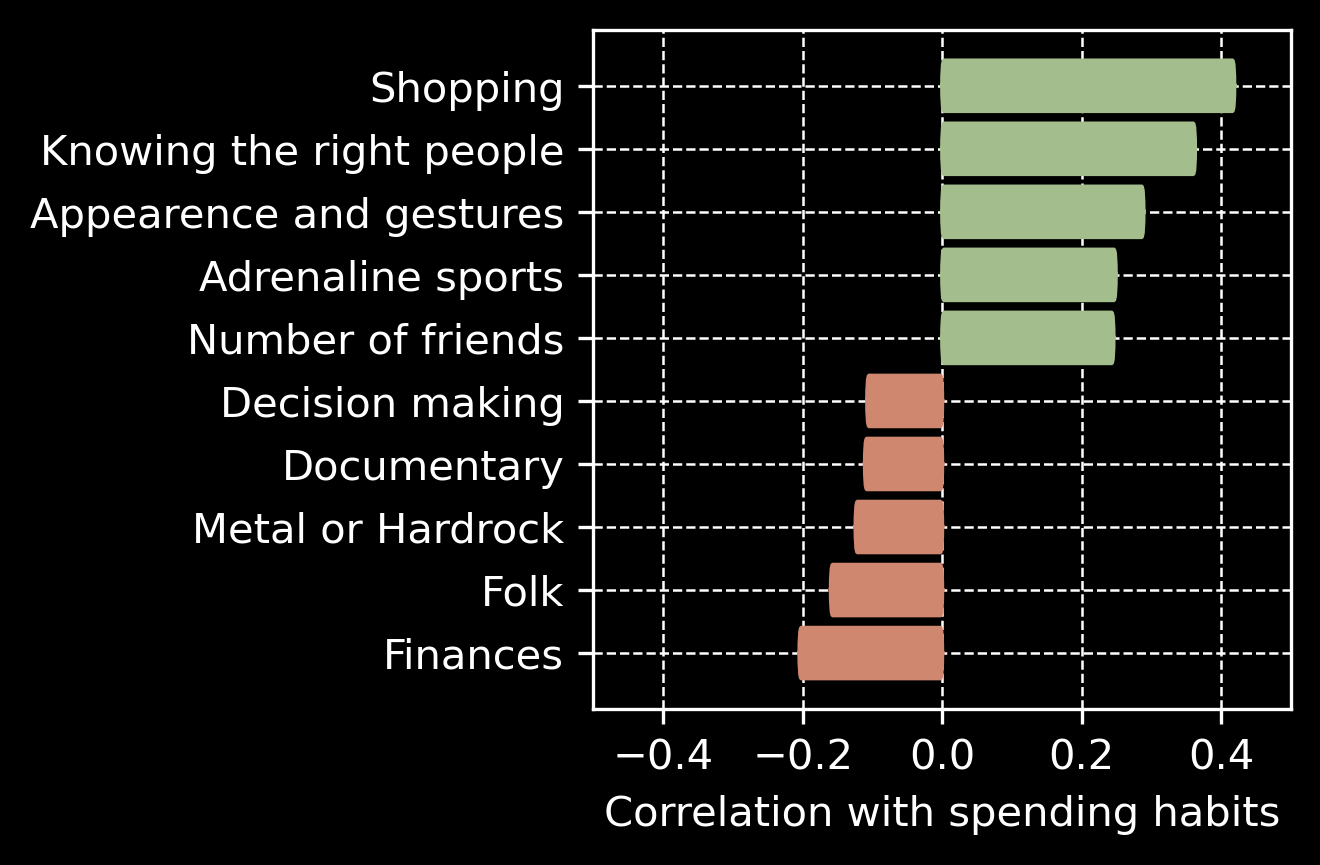

In [31]:
color_list = []

all_cols = numeric_df.columns.drop(spending_list + ["Total Spending"])

indices = numeric_df.corr()["Total Spending"][all_cols].index
values = numeric_df.corr()["Total Spending"][all_cols].values

# since there are many views/habits, only look at the five most strongly
# correlated and anti-correlated items
sorted_idx = np.concatenate((np.argsort(values)[:5], np.argsort(values)[-5:]))
sorted_values = values[sorted_idx]
sorted_indices = indices[sorted_idx]

for val in sorted_values:
    if val < 0:
        color_list.append(nord_aurora_orange)
    else:
        color_list.append(nord_aurora_green)

plt.figure(figsize=(3, 3))
bar = plt.barh(sorted_indices,
               sorted_values,
               zorder=5, color=color_list)

round_bars(bar, rounding_size=0.003, mutation_aspect=indices.shape[0])

plt.xlabel("Correlation with spending habits")
plt.xlim(-0.5, 0.5)
plt.grid(linestyle="dashed", zorder=-1000, linewidth=0.6)
if save_plots:
    plt.savefig("Plots/correlation_full.png", dpi=300, bbox_inches="tight")

plt.show()
plt.close()

Next, let's try to predict the total spending habits from all the available inputs and then check which of the inputs was most important.

# Model data using linear model and visualize results

### Question 4: Which of the various features seem most predictive of the overall spending habits of young people?

In [32]:
# Drop all values that deal with spending habits except for the aggregated
# "Total spending" one

numeric_df.drop(columns=spending_list, inplace=True)

First, we do the splitting into train and test set, then we build a linear model using `sklearn`

In [33]:
y = numeric_df["Total Spending"]
X = numeric_df.drop(columns=["Total Spending"])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,
                                                    random_state=1234)

lm_model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())
lm_model.fit(X_train, y_train) #Fit
print(f"Linear model score: {lm_model.score(X_test, y_test)}")

Linear model score: 0.22419909651123315


In [34]:
# Create Dataframe 
coef_df = coef_weights(lm_model['linearregression'], X_train)

In [35]:
#A quick look at the top results
print("Top ten coefficients")
print(coef_df.head(10))
print("\n\n")
print("Lowest ten coefficients")
print(coef_df.tail(10))

Top ten coefficients
                      est_int     coefs  abs_coefs
57                   Shopping  1.581334   1.581334
115  Knowing the right people  0.710318   0.710318
138                Gender num -0.698428   0.698428
79            Final judgement  0.579403   0.579403
8                        Rock  0.449144   0.449144
128                  Finances -0.428407   0.428407
98         Cheating in school  0.404289   0.404289
108   Appearence and gestures  0.392749   0.392749
99                     Health  0.391385   0.391385
82           Loss of interest  0.354841   0.354841



Lowest ten coefficients
                     est_int     coefs  abs_coefs
127  Questionnaires or polls  0.014834   0.014834
90            Judgment calls -0.014724   0.014724
25                       War  0.013266   0.013266
60          Fun with friends -0.012182   0.012182
73            Healthy eating  0.011448   0.011448
133              Smoking num  0.010097   0.010097
6                    Musical  0.008981   

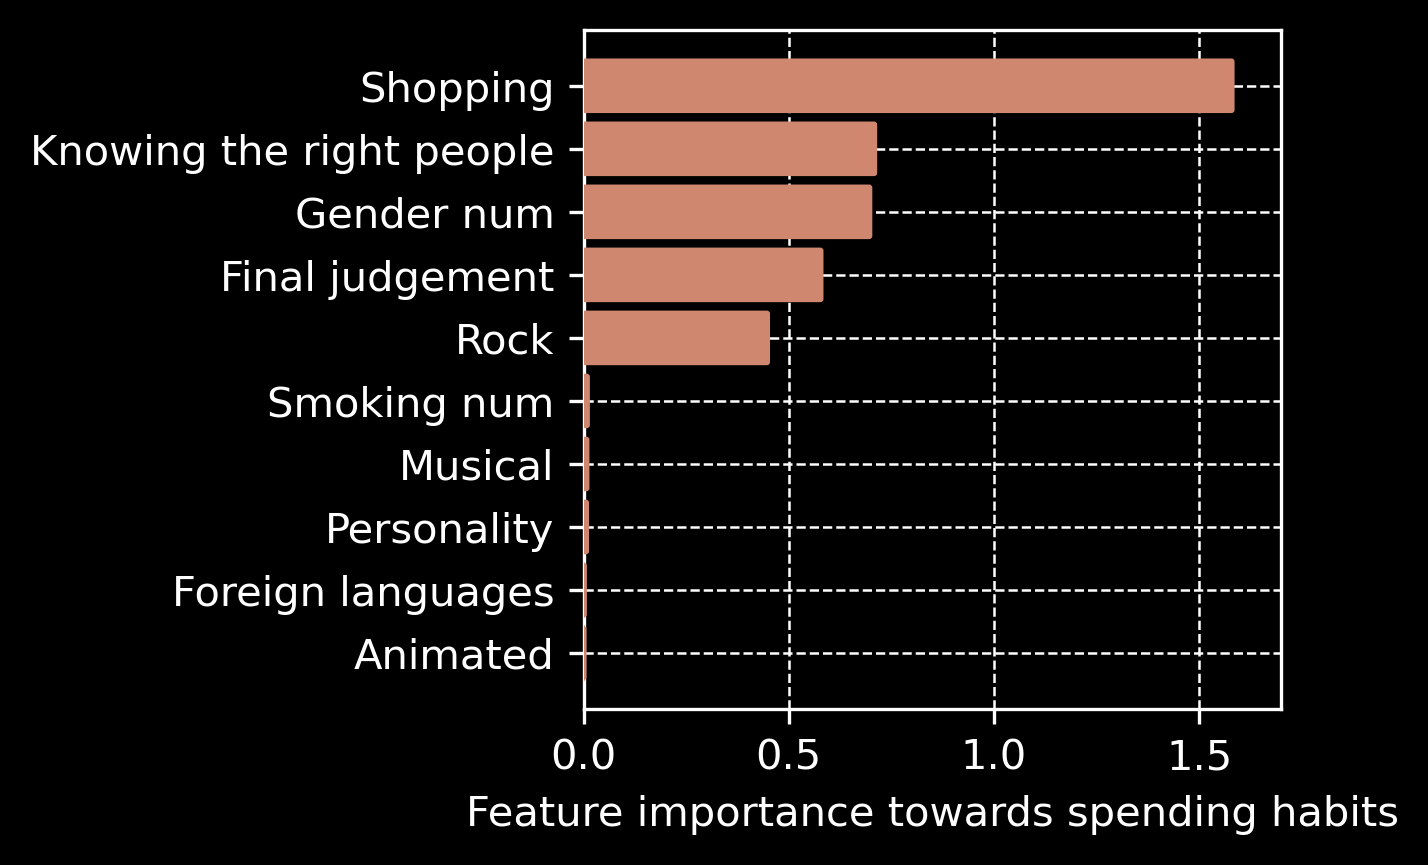

In [36]:
# Plot feature importance
color_list = []

plot_df = pd.concat([coef_df.head(5), coef_df.tail(5)])

indices = plot_df["est_int"][::-1]
values = plot_df["abs_coefs"].values[::-1]

plt.figure(figsize=(3, 3))
bar = plt.barh(indices,
               values,
               zorder=1, color=nord_aurora_orange)

round_bars(bar, rounding_size=0.003, mutation_aspect=10/1.7)
plt.xlabel("Feature importance towards spending habits")
plt.xlim(0, 1.7)
plt.grid(linestyle="dashed", zorder=0, linewidth=0.6)
if save_plots:
    plt.savefig("Plots/importance_linear.png", dpi=300, bbox_inches="tight")

plt.show()
plt.close()

This is an interesting result! We see many categories that we would expect on top - especially the "Shopping" one. Also, as discussed previously, "Knowing the right people" tends not only to be highly correlated with the spending habits, it also seems to be an important feature for prediction. The Gender also seems to play an important role, which was also discussed before when looking at the total spending distribution and doing a hypothesis test, which showed that their spending habits differ significantly, even though the feature was not strongly correlated with it. What I would not have expected is to find rock music here - maybe our business intelligence unit should look into this finding. 

Also on the lower end, there are some categories I would not have expected here: In most "western" countries, smoking is extremely expensive, which is why I would have expected this category to have a high predictive importance. Also going to musicals can be a rather expensive hobby, since ticket prices aren't exactly cheap. Still this category also does not seem to have a very high importance when trying to predict spending habits.

Let's see if we can improve the result a bit using a DNN model:

In [37]:
# define regression model
regr = make_pipeline(StandardScaler(with_mean=False), MLPRegressor(random_state=42, hidden_layer_sizes=(10,),max_iter=1800)).fit(X_train, y_train)
regr.predict(X_test)

regr.score(X_test, y_test)

0.29387039962746087

We get an R2 score of about 0.3, which is better than the linear model, but still not very good. Even using machine learning, we cannot predict spending habits from behavioral aspects very well, which means it is overall quite a challenging task.

In [38]:
coef_df_mlp = coef_weights(regr['mlpregressor'], X_train, model_type="mlp")

In [39]:
coef_df_mlp.sort_values('abs_coefs', ascending=False)[:10]

,est_int,coefs,abs_coefs
57,Shopping,2.848332,3.065856
115,Knowing the right people,1.520408,1.877499
128,Finances,-1.507619,1.580334
79,Final judgement,0.863638,1.564257
108,Appearence and gestures,1.268951,1.473116
110,Achievements,0.771249,1.449440
138,Gender num,-0.981685,1.419738
101,God,-0.551382,1.341672
47,Art exhibitions,0.747257,1.335439
99,Health,1.127832,1.319395


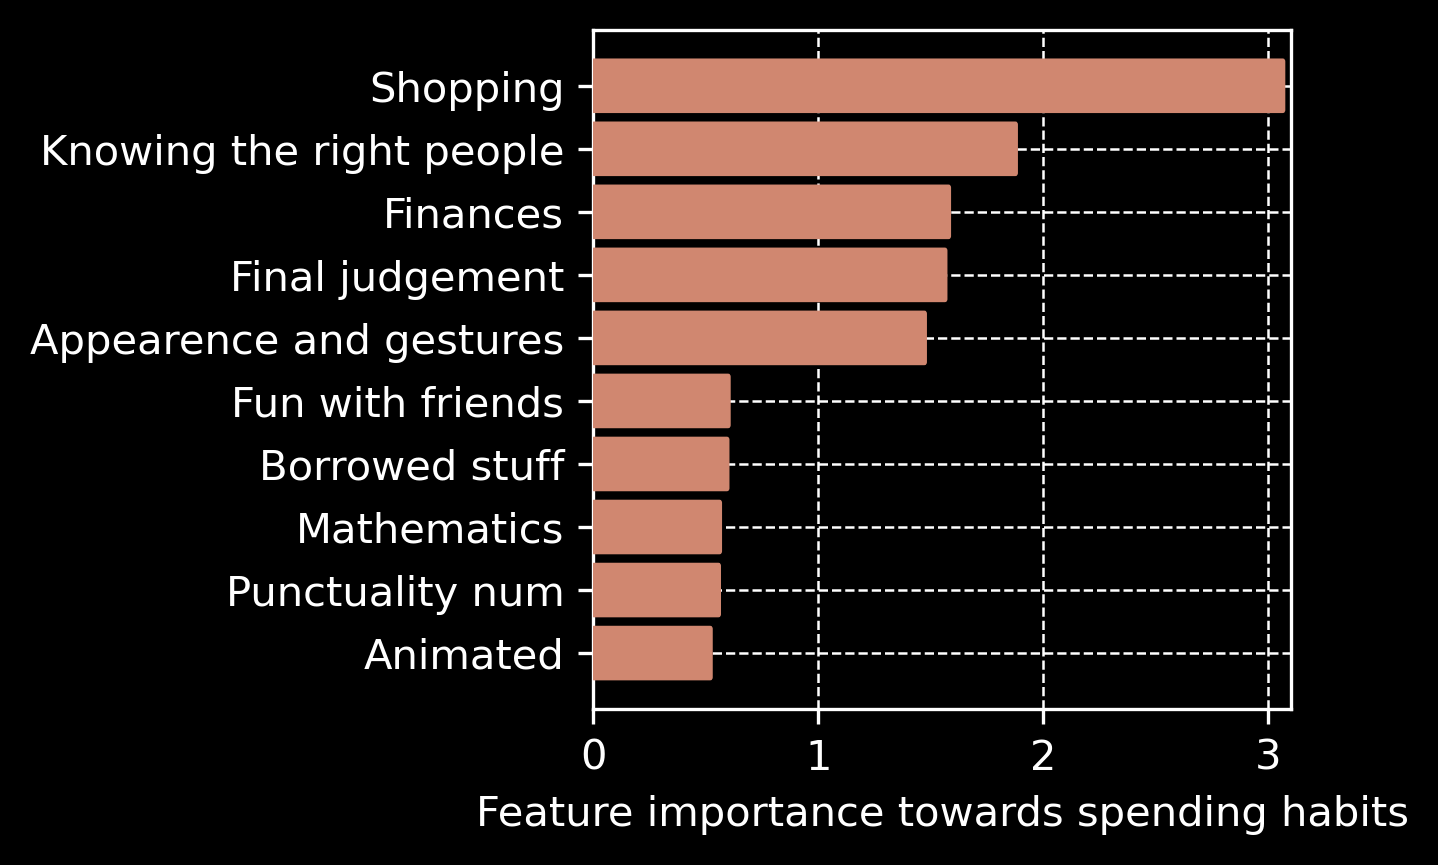

In [40]:
# Plot feature importance
color_list = []

plot_df = pd.concat([coef_df_mlp.head(5), coef_df_mlp.tail(5)])

indices = plot_df["est_int"][::-1]
values = plot_df["abs_coefs"].values[::-1]

plt.figure(figsize=(3, 3))
bar = plt.barh(indices,
               values,
               zorder=1, color=nord_aurora_orange)

round_bars(bar, rounding_size=0.003, mutation_aspect=10/1.7)
plt.xlabel("Feature importance towards spending habits")
plt.xlim(0, 3.1)
plt.grid(linestyle="dashed", zorder=0, linewidth=0.6)
if save_plots:
    plt.savefig("Plots/importance_mlp.png", dpi=300, bbox_inches="tight")

plt.show()
plt.close()

Using the simple approach of looking at the absolute sum of weights in the first layer for each input to get a measure for feature importance, we see a similar result: Shopping as a hobby and knowing the right people still seem to be the most important features. In addition, the final judgement feature is present again. Also, as one would expect, the "Finances" feature is now present, which describes the agreement with the statement "*I save all the money I can*". This is expected to show up here, since people that save a lot of money should have low "Total Spending" values and vice-versa.